In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click to view/hide code"></form>''')



# Formula 1 2024 Track Performance Analysis and Prediction

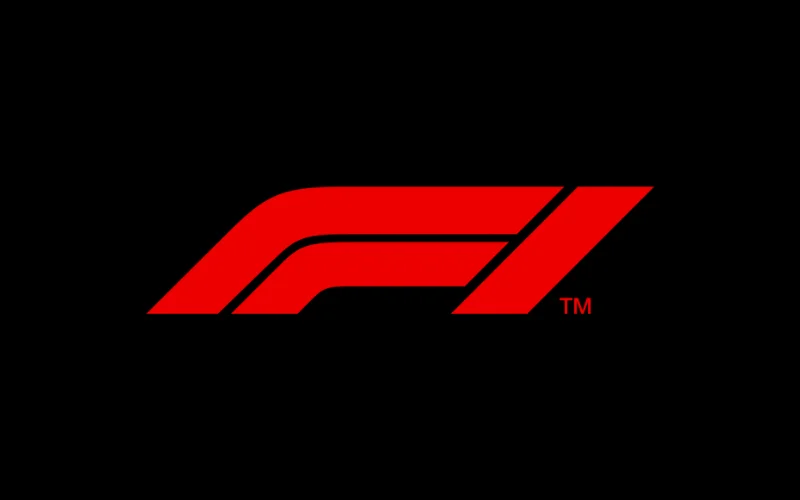

The main goal of this project is to predict the results of each Formula 1 race from the 14th round (Belgian Grand Prix) onwards in the 2024 season. This is achieved through analysis, data visualization of track characteristics, and assessment of team adaptability to different circuits.

The initial model employs a simple linear approach. The features selected are based on my years of observing F1 race and accumulated knowledge from continuous attention to F1 technology. The primary focus is on classifying tracks as high, medium, or low speed, and using team race ranking momentum (adjusted) for predictions.

With the introduction of ground effect era in 2022, maintaining a consistent chassis height became paramount. The design of suspension and chassis is crucial for generating stable downforce through the Venturi tunnels. Ground effect has further amplified the performance differences of various car designs across different track characteristics. For instance, Red Bull excels on traditional circuits with multiple high-speed corners, while Ferrari leverages its superior mechanical grip on low-speed tracks. We've also observed McLaren's stronger adaptability to different circuits, potentially challenging Red Bull's dominance this season.

Through diverse data visualization and analysis approaches, this project aims to predict the specific point performance of each driver at every race. It's important to note that our predictions do not include sprint races for future events.

Additionally, while I hoped to incorporate DRS coverage or track straight length data, unfortunately, this information was not available. I believe these two factors would provide better measures of a vehicle's acceleration and top speed capabilities.

This project will provide insights into F1 performance prediction, showcasing the intricate relationship between track characteristics and race results in the high-tech world of Formula 1 racing.

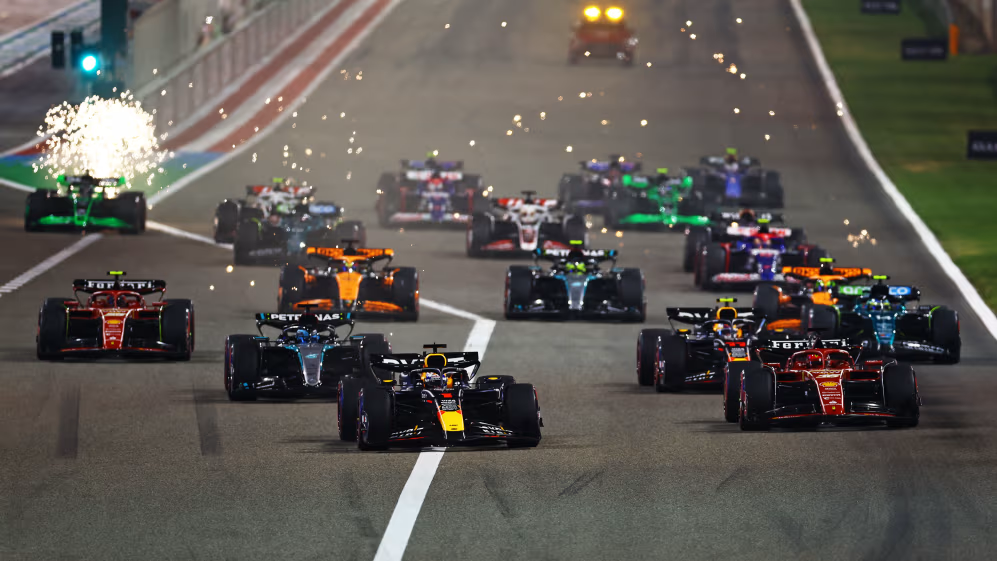

## Speed visualization on track map
#### First, we will create a speed visualization of all the tracks from the 2023 season. This will give us a general understanding of whether the tracks analyzed later are high-speed or low-speed. In this visualization, I will use Verstappen's qualifying data from 2023 as the standard.

In [1]:
import fastf1 as ff1
import pandas as pd
import logging
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
import os

# Suppress all warnings
warnings.filterwarnings("ignore")
logging.getLogger('fastf1').setLevel(logging.CRITICAL)

# Context manager to suppress stdout and stderr
class SuppressOutput:
    def __init__(self):
        self._stdout = None
        self._stderr = None
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for _ in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

# Enable cache to speed up data loading
ff1.Cache.enable_cache('/Users/sk_sunflower163.com/Library/Caches/fastf1')

# Set year and session type
year = 2023
sessions = ['Q']  # Only include Qualifying
driver = 'VER'  # Max Verstappen's code

# All races and qualifying sessions in 2023
num_rounds = 22  # Assuming 22 rounds in 2023

# Set up the grid layout
num_cols = 3  # Number of columns in the grid
num_rows = (num_rounds + num_cols - 1) // num_cols  # Calculate number of rows needed

# Create a single figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows), squeeze=False)
fig.suptitle(f'{year} {driver} Qualifying Speed Visualizations', size=24, y=0.95)

# Use tqdm to create a progress bar
for wknd in tqdm(range(1, num_rounds + 1), desc="Processing Qualifying Sessions"):
    try:
        with SuppressOutput():
            # Load race session
            session = ff1.get_session(year, wknd, 'Q')
            session.load(telemetry=True)
            
            # Extract the fastest lap data for the driver
            lap = session.laps.pick_driver(driver).pick_fastest()
            
            # Get Telemetry data
            x = lap.telemetry['X']              # x-axis data (track coordinates)
            y = lap.telemetry['Y']              # y-axis data (track coordinates)
            speed = lap.telemetry['Speed']      # speed data for color mapping
        
        # Create line segment data for color mapping
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Get the current subplot
        row = (wknd - 1) // num_cols
        col = (wknd - 1) % num_cols
        ax = axs[row, col]
        
        # Set the subplot title
        ax.set_title(f'{session.event["EventName"]}', size=10)
        
        # Turn off axes
        ax.axis('off')
        
        # Maintain aspect ratio
        ax.set_aspect('equal', 'box')
        
        # Plot the track background line (increased linewidth to 4)
        ax.plot(x, y, color='black', linestyle='-', linewidth=4, zorder=0)
        
        # Create a normalizer for color mapping
        norm = plt.Normalize(speed.min(), speed.max())
        lc = LineCollection(segments, cmap=plt.cm.inferno, norm=norm,
                            linestyle='-', linewidth=2)  # Increased linewidth to 2
        
        # Set the values used for colormapping
        lc.set_array(speed)
        
        # Add the line segments to the plot
        line = ax.add_collection(lc)
        
        # Add a color bar to each subplot
        cbar = fig.colorbar(lc, ax=ax, orientation='vertical', shrink=0.6)
        cbar.set_label('Speed [km/h]', size=8)
        cbar.ax.tick_params(labelsize=6)
        
    except Exception as e:
        tqdm.write(f"Failed to process data for {year} round {wknd}: {e}")
        # If there's an error, just leave the subplot empty
        axs[row, col].axis('off')

# Remove any unused subplots
for i in range(wknd, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axs[row, col])

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust this value to prevent title overlap
plt.show()


/Users/sk_sunflower163.com/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
Processing Qualifying Sessions: 100%|███████████| 22/22 [01:00<00:00,  2.76s/it]


## Stats on Tracks

As shown in the next image, I will analyze Max Verstappen's speed at each corner on every track's every corners to categorize and count the number of high-speed, med-speed, and low-speed corners of each track.

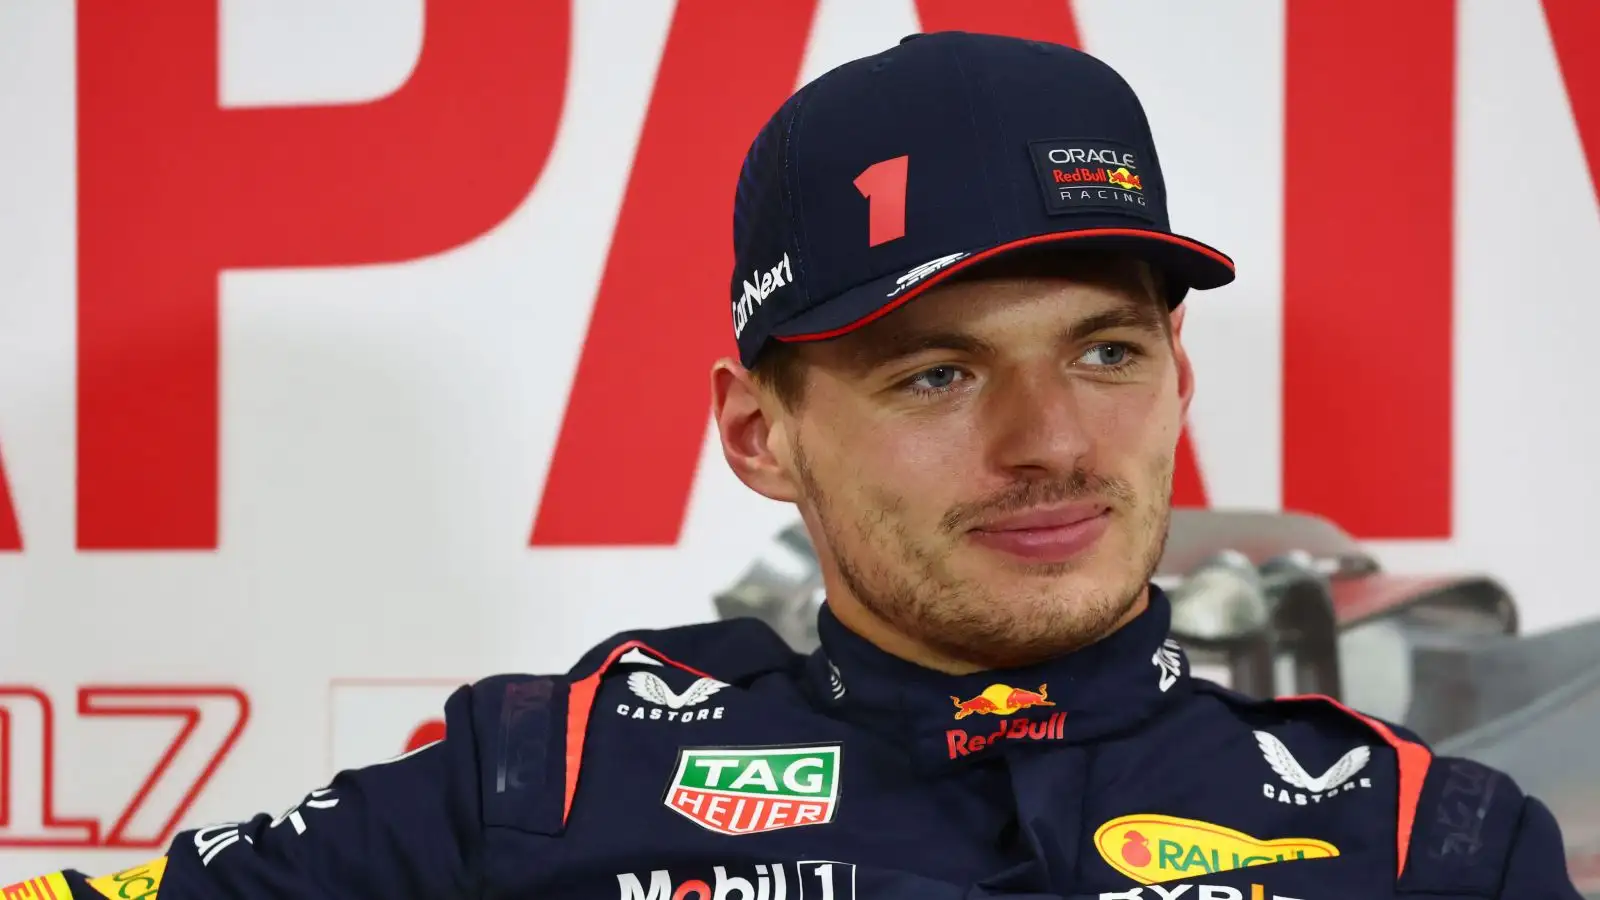

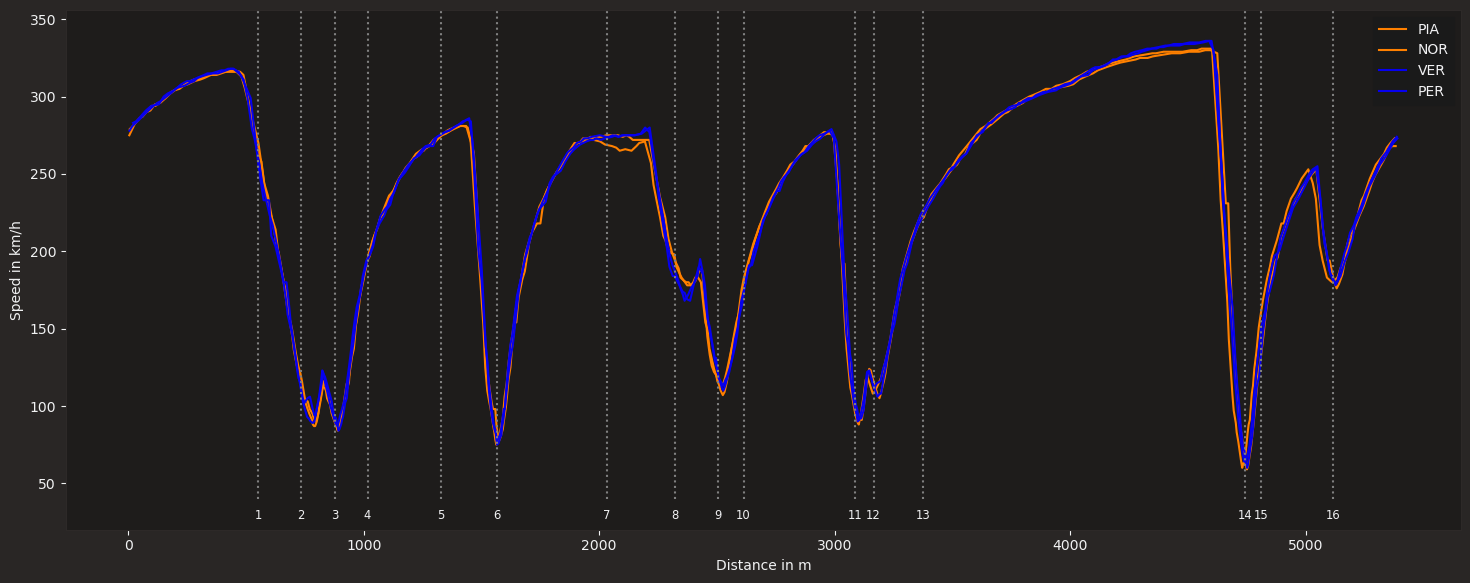

In [3]:
import fastf1.plotting

# Enable Matplotlib and FastF1 settings
ff1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False, color_scheme='fastf1')

# Set the year and race information
year = 2024
grand_prix = 5
session_type = 'Q'

# Load the session data
session = ff1.get_session(year, grand_prix, session_type)
session.load()

# Select drivers
drivers = ['PIA', 'NOR', 'VER', 'PER']  # Driver codes for Piastri, Norris, Verstappen, and Perez

# Create the plot with a wider figure size
fig, ax = plt.subplots(figsize=(18, 6.75))

# Iterate over each driver and plot the data
for driver in drivers:
    fastest_lap = session.laps.pick_driver(driver).pick_fastest()
    car_data = fastest_lap.get_car_data().add_distance()
    
    team_color = ff1.plotting.get_team_color(fastest_lap['Team'], session=session)
    ax.plot(car_data['Distance'], car_data['Speed'], color=team_color, label=fastest_lap['Driver'])

# Plot the corner information
circuit_info = session.get_circuit_info()
v_min = car_data['Speed'].min()
v_max = car_data['Speed'].max()
ax.vlines(x=circuit_info.corners['Distance'], ymin=v_min-20, ymax=v_max+20, linestyles='dotted', colors='grey')

# Annotate corner positions with corner numbers
for _, corner in circuit_info.corners.iterrows():
    txt = f"{corner['Number']}{corner['Letter']}"
    ax.text(corner['Distance'], v_min-30, txt, va='center_baseline', ha='center', size='small')

# Set axis labels and legend
ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')
ax.legend()

# Adjust y-axis range to include corner numbers
ax.set_ylim([v_min - 40, v_max + 20])

# Display the plot
plt.show()




## Categorizing the corners at each track.

In this code, I categorize and count the number of low-speed, medium-speed, and high-speed corners on each circuit based on Max Verstappen's speed at each corner. Corners are classified as low-speed if they are below 130 km/h, medium-speed between 130 km/h and 200 km/h, and high-speed if they exceed 200 km/h.

In addition to analyzing the tracks from the 2023 season, I will also include data for the 2024 Chinese Grand Prix and Emilia Romagna Grand Prix. Since the 2023 season did not feature the Chinese Grand Prix and the Emilia Romagna Grand Prix was canceled, the 2023 data alone is insufficient to cover all the circuits that will be featured in the 2024 season.

Processing Grands Prix: 100%|███████████████████| 24/24 [00:41<00:00,  1.74s/it]


Percentage data saved to verstappen_2023_2024_corner_percentage.csv

Percentage Data Sample:
Type  Year                  Track  High_Pct   Low_Pct  Medium_Pct
0     2023   Abu Dhabi Grand Prix  0.437500  0.250000    0.312500
1     2023  Australian Grand Prix  0.571429  0.142857    0.285714
2     2023    Austrian Grand Prix  0.700000  0.200000    0.100000
3     2023  Azerbaijan Grand Prix  0.300000  0.550000    0.150000
4     2023     Bahrain Grand Prix  0.333333  0.200000    0.466667

Corner type counts per track:
Type                       High  Low  Medium
Track                                       
Abu Dhabi Grand Prix          7    4       5
Australian Grand Prix         8    2       4
Austrian Grand Prix           7    2       1
Azerbaijan Grand Prix         6   11       3
Bahrain Grand Prix            5    3       7
Belgian Grand Prix            9    4       6
British Grand Prix           12    3       3
Canadian Grand Prix           2    6       6
Chinese Grand Prix            

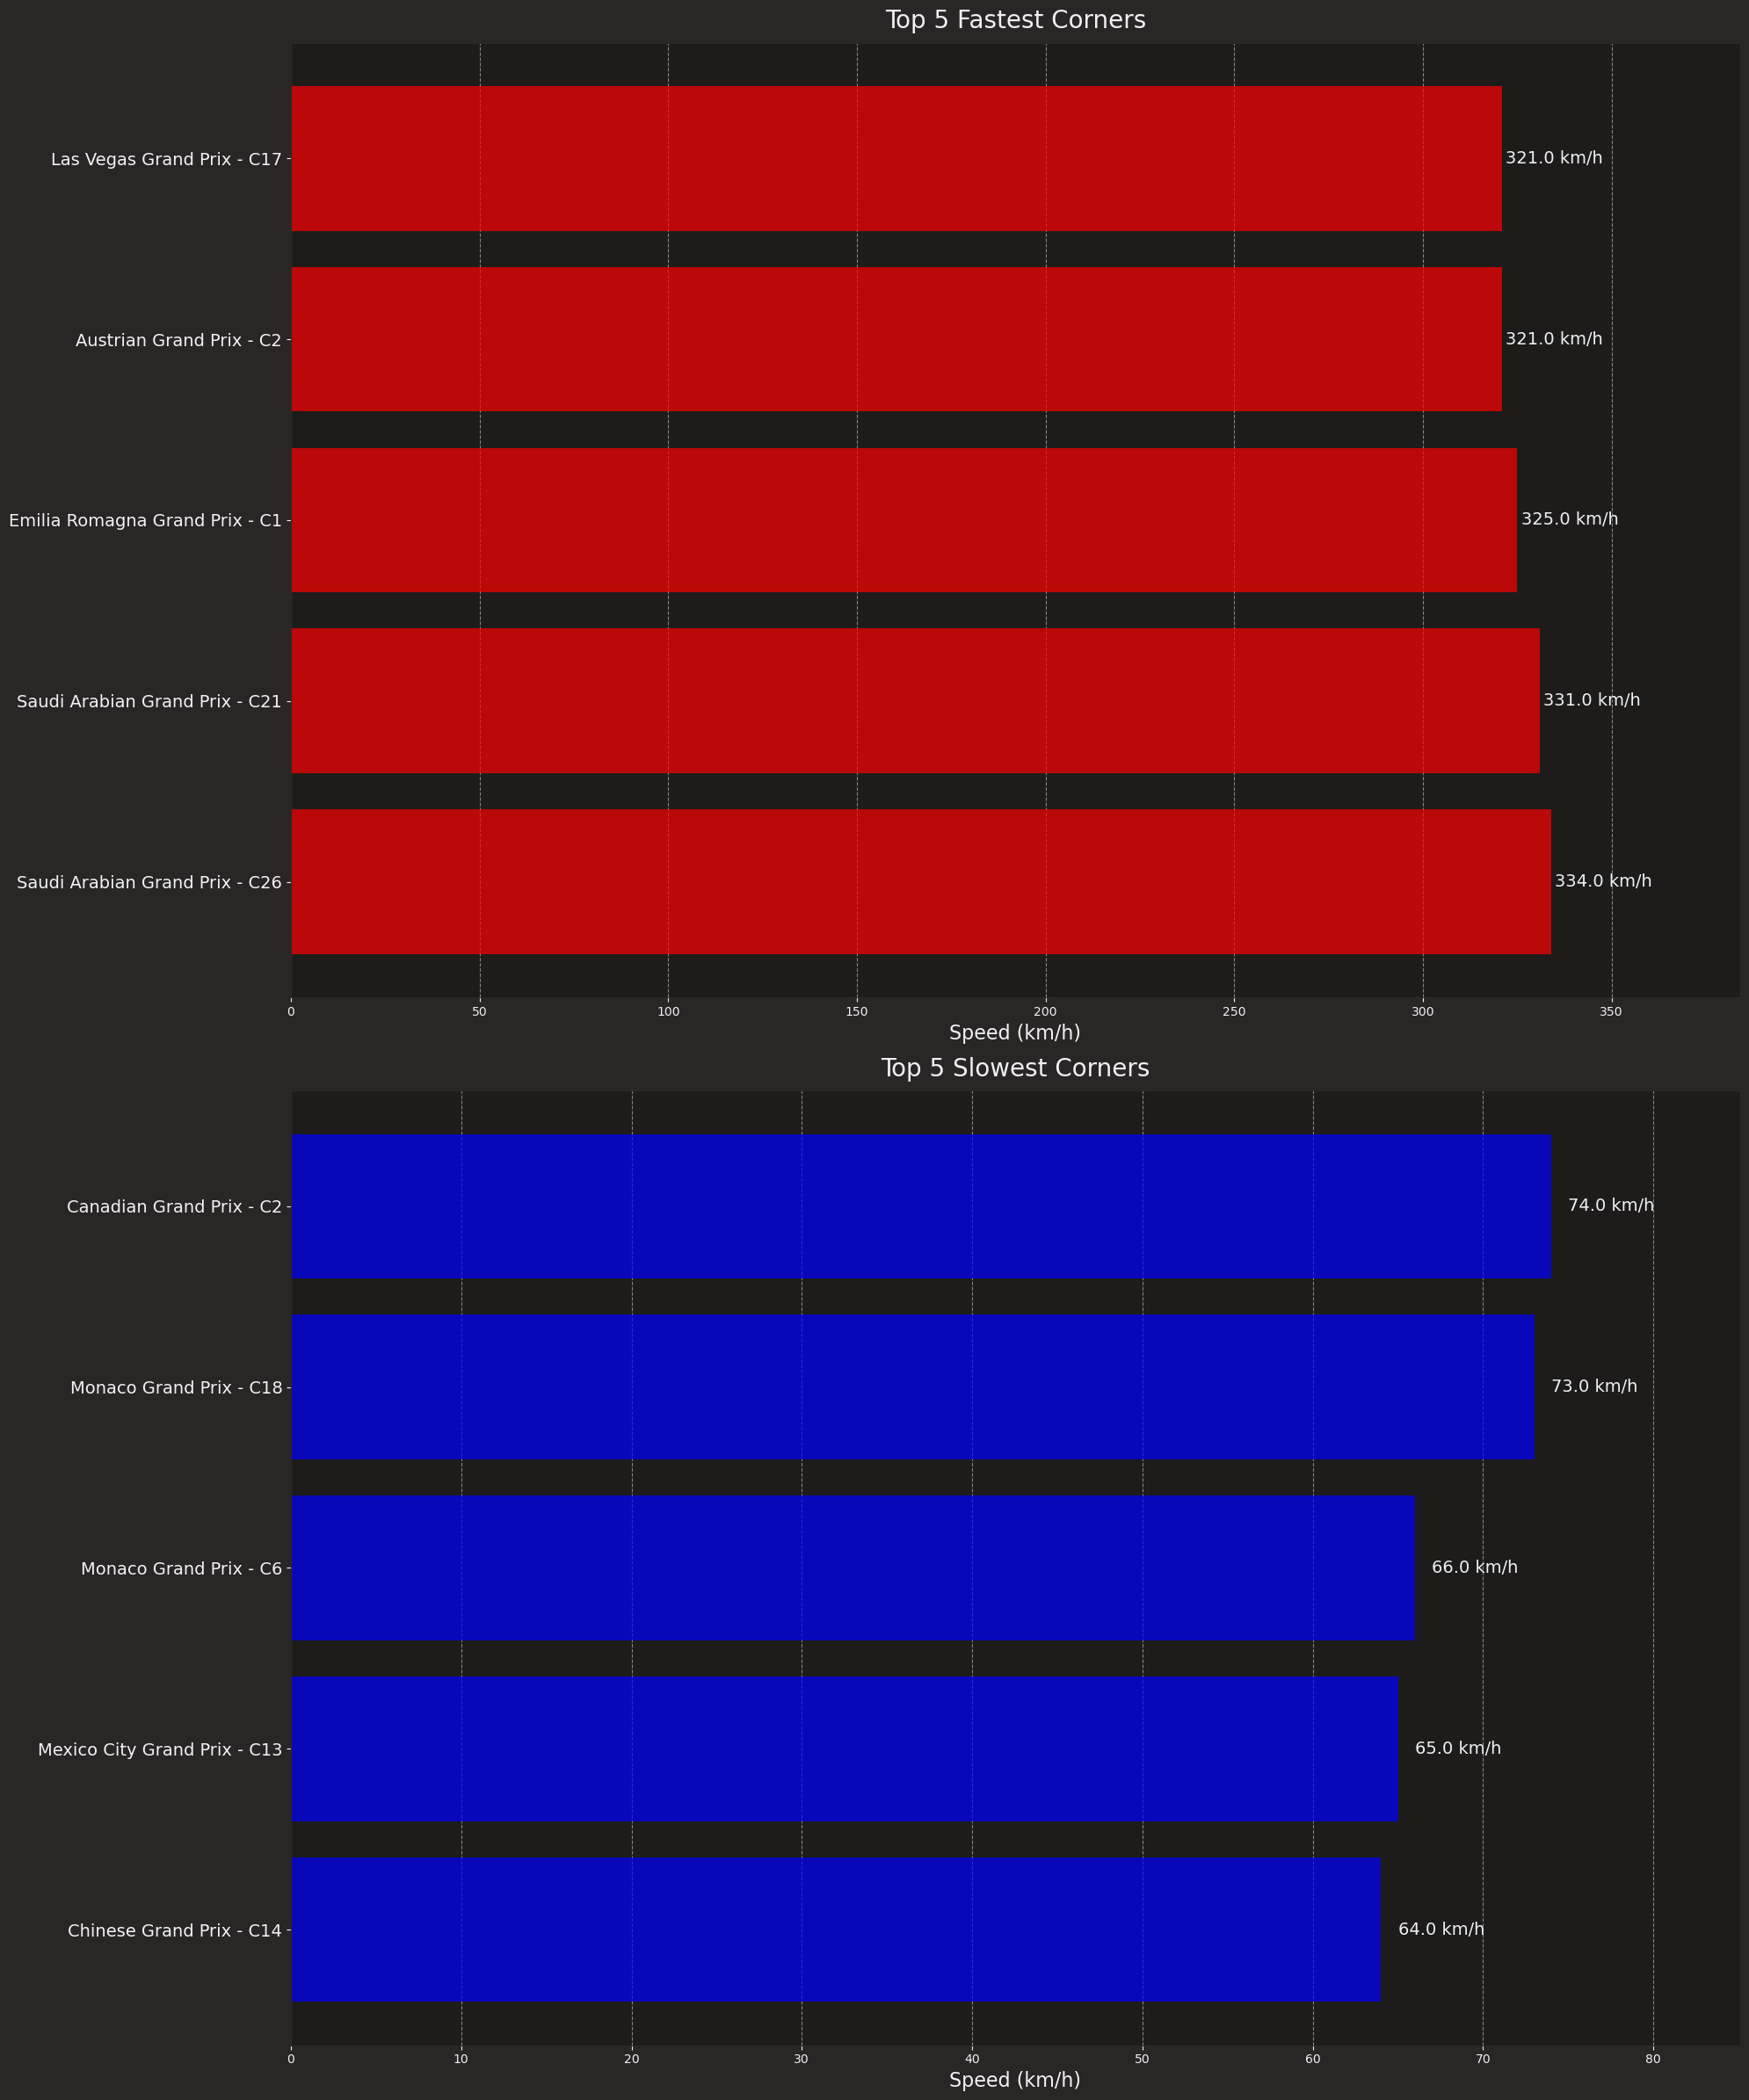


Top 5 Fastest Corners:
     Year                      Track Corner  Speed
40   2023   Saudi Arabian Grand Prix     26  334.0
35   2023   Saudi Arabian Grand Prix     21  331.0
384  2024  Emilia Romagna Grand Prix      1  325.0
143  2023        Austrian Grand Prix      2  321.0
351  2023       Las Vegas Grand Prix     17  321.0

Top 5 Slowest Corners:
     Year                   Track Corner  Speed
381  2024      Chinese Grand Prix     14   64.0
315  2023  Mexico City Grand Prix     13   65.0
100  2023       Monaco Grand Prix      6   66.0
112  2023       Monaco Grand Prix     18   73.0
129  2023     Canadian Grand Prix      2   74.0


In [4]:
import fastf1 as ff1
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Enable caching to speed up data loading
ff1.Cache.enable_cache('/Users/sk_sunflower163.com/Library/Caches/fastf1')

def classify_corner(speed):
    if speed < 130:
        return 'Low'
    elif 130 <= speed <= 200:
        return 'Medium'
    else:
        return 'High'

def process_session(year, round, session_type='Q'):
    try:
        session = ff1.get_session(year, round, session_type)
        session.load()

        circuit_info = session.get_circuit_info()
        track_name = session.event['EventName']

        fastest_lap = session.laps.pick_driver('VER').pick_fastest()
        car_data = fastest_lap.get_car_data().add_distance()

        corner_speeds = []
        corner_numbers = []
        corner_types = []

        for idx, corner in circuit_info.corners.iterrows():
            corner_distance = corner['Distance']
            closest_idx = (car_data['Distance'] - corner_distance).abs().idxmin()
            speed_at_corner = car_data.loc[closest_idx, 'Speed']
            corner_speeds.append(float(speed_at_corner))
            corner_numbers.append(idx)
            corner_types.append(classify_corner(speed_at_corner))

        corner_data = pd.DataFrame({
            'Year': year,
            'Track': track_name,
            'Corner': corner_numbers,
            'Speed': corner_speeds,
            'Type': corner_types
        })

        return corner_data
    except Exception as e:
        print(f"Error processing {year} round {round}: {e}")
        return None

# Create a DataFrame to store corner data
all_corners = pd.DataFrame(columns=['Year', 'Track', 'Corner', 'Speed', 'Type'])

# Process all the Grands Prix in 2023 and 2024 with progress bar
total_rounds = 24  # 22 for 2023 + 2 for 2024
with tqdm(total=total_rounds, desc="Processing Grands Prix") as pbar:
    # Process 2023 Grands Prix
    for round in range(1, 23):  # 22 Grands Prix in 2023
        corner_data = process_session(2023, round)
        if corner_data is not None:
            all_corners = pd.concat([all_corners, corner_data], ignore_index=True)
        pbar.update(1)

    # Process the 2024 Chinese Grand Prix
    shanghai_corners = process_session(2024, 'Chinese Grand Prix')
    if shanghai_corners is not None:
        all_corners = pd.concat([all_corners, shanghai_corners], ignore_index=True)
    pbar.update(1)

    # Process the 2024 Emilia Romagna Grand Prix
    imola_corners = process_session(2024, 'Emilia Romagna Grand Prix')
    if imola_corners is not None:
        all_corners = pd.concat([all_corners, imola_corners], ignore_index=True)
    pbar.update(1)

# Ensure 'Speed' column is numeric
all_corners['Speed'] = pd.to_numeric(all_corners['Speed'], errors='coerce')

# Calculate percentages of corner types for each track
corner_percentages = all_corners.groupby(['Year', 'Track', 'Type']).size().unstack(fill_value=0)
corner_percentages = corner_percentages.div(corner_percentages.sum(axis=1), axis=0)
corner_percentages = corner_percentages.rename(columns={'Low': 'Low_Pct', 'Medium': 'Medium_Pct', 'High': 'High_Pct'})
corner_percentages = corner_percentages.reset_index()

# Save percentage data to a CSV file
corner_percentages.to_csv('verstappen_2023_2024_corner_percentage.csv', index=False)
print("Percentage data saved to verstappen_2023_2024_corner_percentage.csv")

# Print sample data
print("\nPercentage Data Sample:")
print(corner_percentages.head())

# Count the number of each type of corner per track
corner_counts = all_corners.groupby(['Track', 'Type']).size().unstack(fill_value=0)
print("\nCorner type counts per track:")
print(corner_counts)

# Find top 5 fastest and slowest corners across all tracks
top_5_fastest = all_corners.nlargest(5, 'Speed')
top_5_slowest = all_corners.nsmallest(5, 'Speed')

def create_combined_bar_plot(fastest, slowest):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 24))  # Increase figure height

    def plot_bar(ax, data, title, color):
        labels = [f"{data['Track'].iloc[i]} - C{data['Corner'].iloc[i]+1}" for i in range(len(data))]
        y = range(len(data))
        bars = ax.barh(y, data['Speed'], color=color, alpha=0.7)  # Use horizontal bars
     
        for i, v in enumerate(data['Speed']):
            ax.text(v + 1, i, f'{v:.1f} km/h', va='center', fontsize=14)  # Increase font size

        ax.set_yticks(y)
        ax.set_yticklabels(labels, fontsize=14)  # Increase font size
        ax.set_xlabel('Speed (km/h)', fontsize=16)
        ax.set_title(title, size=20)

        ax.grid(True, axis='x', linestyle='--', alpha=0.7)

        x_max = max(data['Speed']) * 1.15  
        ax.set_xlim(0, x_max)

    plot_bar(ax1, fastest, 'Top 5 Fastest Corners', 'red')
    plot_bar(ax2, slowest, 'Top 5 Slowest Corners', 'blue')

    plt.tight_layout()
    plt.show()


create_combined_bar_plot(top_5_fastest, top_5_slowest)


print("\nTop 5 Fastest Corners:")
print(top_5_fastest[['Year', 'Track', 'Corner', 'Speed']].assign(Corner=lambda x: x['Corner'] + 1))

print("\nTop 5 Slowest Corners:")
print(top_5_slowest[['Year', 'Track', 'Corner', 'Speed']].assign(Corner=lambda x: x['Corner'] + 1))

# GEO VS Track Type
Let's explore the types of tracks preferred in different countries.

The overall speed of the track is measured using the ratio of high- and medium-speed corners versus medium- and low-speed corners.

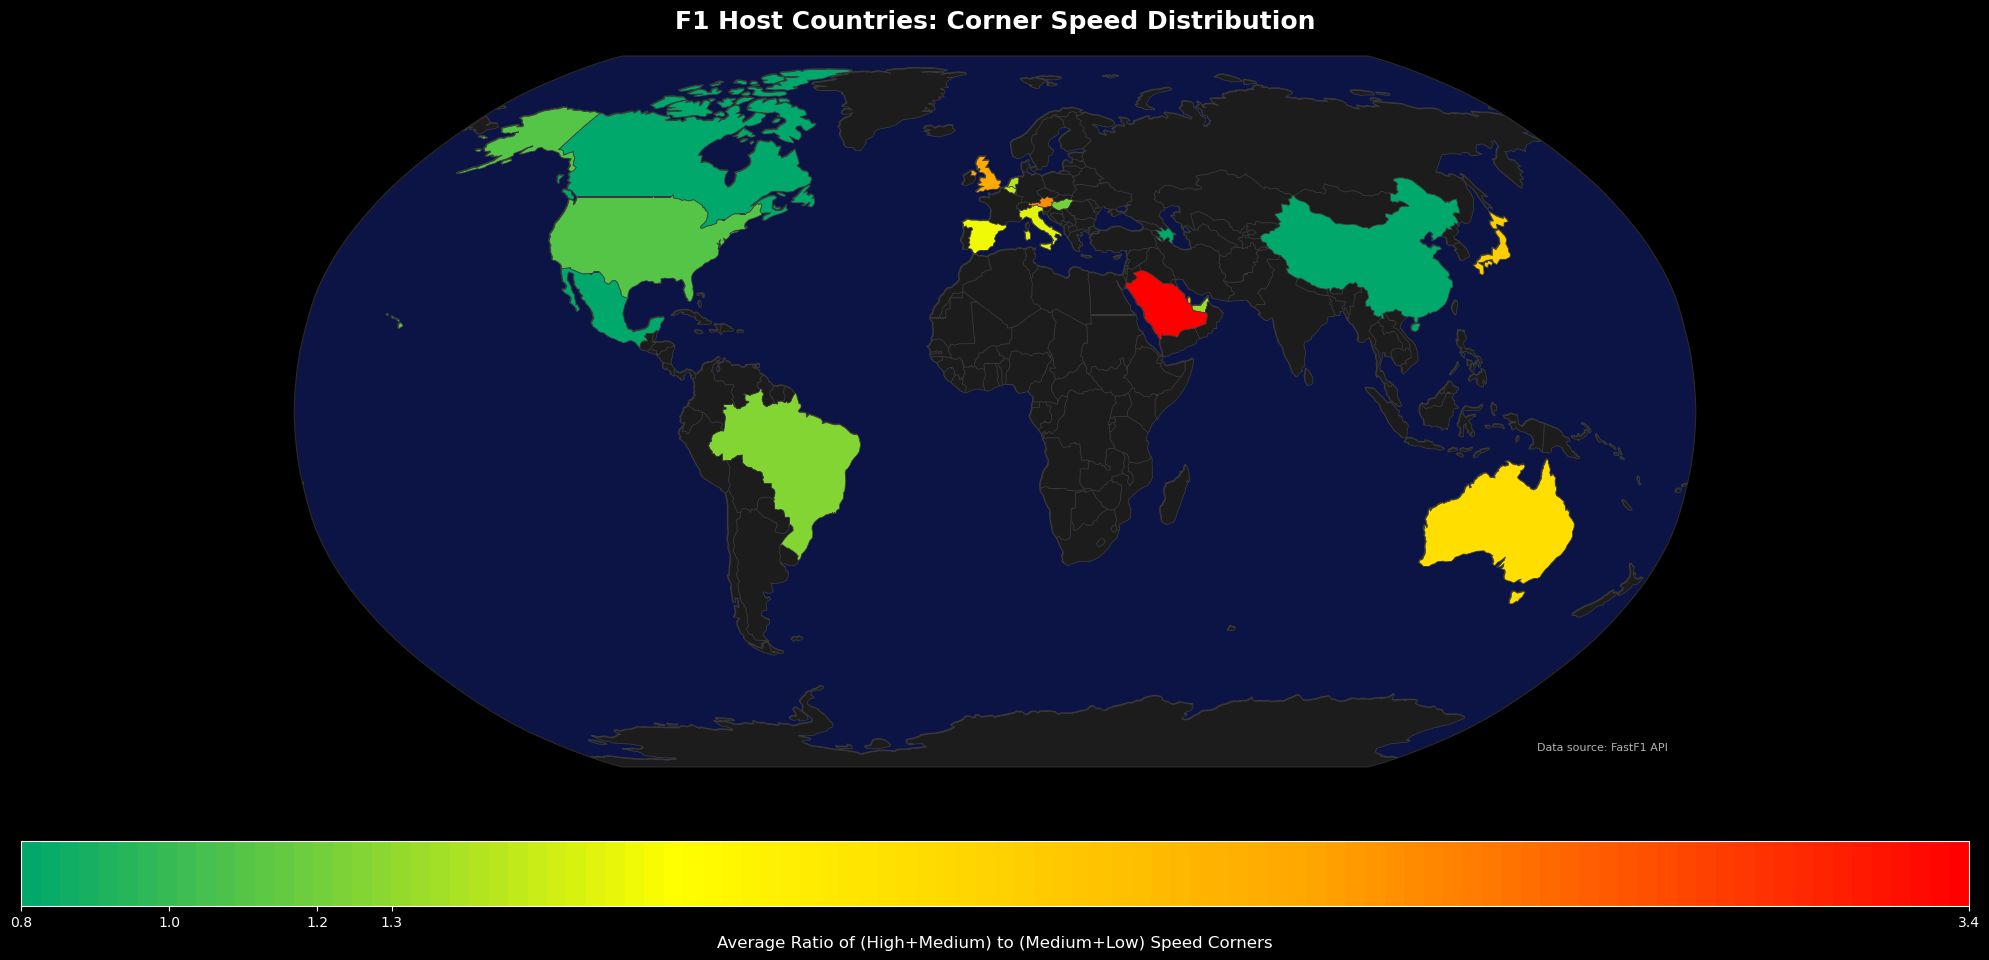

                     Country     Ratio
0                  Australia  2.000000
1                    Austria  2.666667
2                 Azerbaijan  0.642857
3                    Bahrain  1.200000
4                    Belgium  1.500000
5                     Brazil  1.250000
6                     Canada  0.666667
7                      China  0.750000
8                    Hungary  1.200000
9                      Italy  1.566667
10                     Japan  2.142857
11                    Mexico  0.571429
12                    Monaco  0.666667
13               Netherlands  1.428571
14                     Qatar  2.500000
15              Saudi Arabia  3.428571
16                 Singapore  0.800000
17                     Spain  1.625000
18      United Arab Emirates  1.333333
19            United Kingdom  2.500000
20  United States of America  1.114815


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Grand Prix to Country mapping
gp_country_mapping = {
    'United States Grand Prix': 'United States of America',
    'Azerbaijan Grand Prix': 'Azerbaijan',
    'Spanish Grand Prix': 'Spain',
    'Hungarian Grand Prix': 'Hungary',
    'Emilia Romagna Grand Prix': 'Italy',
    'Saudi Arabian Grand Prix': 'Saudi Arabia',
    'Las Vegas Grand Prix': 'United States of America',
    'Qatar Grand Prix': 'Qatar',
    'Australian Grand Prix': 'Australia',
    'Mexico City Grand Prix': 'Mexico',
    'Miami Grand Prix': 'United States of America',
    'Monaco Grand Prix': 'Monaco',
    'Canadian Grand Prix': 'Canada',
    'Italian Grand Prix': 'Italy',
    'Bahrain Grand Prix': 'Bahrain',
    'Chinese Grand Prix': 'China',
    'British Grand Prix': 'United Kingdom',
    'Singapore Grand Prix': 'Singapore',
    'Belgian Grand Prix': 'Belgium',
    'Austrian Grand Prix': 'Austria',
    'Japanese Grand Prix': 'Japan',
    'Abu Dhabi Grand Prix': 'United Arab Emirates',
    'Dutch Grand Prix': 'Netherlands',
    'São Paulo Grand Prix': 'Brazil'
}

# Read and process data
results = pd.read_csv('verstappen_2023_2024_corner_percentage.csv')
coordinates = pd.read_csv('f1_2024_selected_race_locations_and_years.csv')
merged_data = pd.merge(results, coordinates, left_on='Track', right_on='name', how='left')
merged_data['Country'] = merged_data['Track'].map(gp_country_mapping)
merged_data['High_Medium'] = merged_data['High_Pct'] + merged_data['Medium_Pct']
merged_data['Medium_Low'] = merged_data['Medium_Pct'] + merged_data['Low_Pct']
merged_data['Ratio'] = merged_data['High_Medium'] / merged_data['Medium_Low']
country_ratios = merged_data.groupby('Country')['Ratio'].mean().reset_index()

# Create custom colormap
colors = ['#00A86B', '#FFFF00', '#FFA500', '#FF0000']  # Green to Yellow to Orange to Red
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Create plot
fig = plt.figure(figsize=(20, 10), facecolor='black')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# Set background color
ax.set_facecolor('black')

# Add map features
ax.set_global()
ax.add_feature(cfeature.OCEAN, facecolor='#0c1445')  # Deep blue for ocean
ax.add_feature(cfeature.LAND, facecolor='#1c1c1c')
ax.add_feature(cfeature.COASTLINE, edgecolor='#3a3a3a')
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='#3a3a3a')

# Load and plot countries
shpfilename = shapereader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
reader = shapereader.Reader(shpfilename)
countries = reader.records()

# Adjust normalization to include ratios above 1.3
min_ratio = 0.8
max_ratio = max(1.5, country_ratios['Ratio'].max())  # Use 1.5 or the highest ratio, whichever is greater
norm = Normalize(vmin=min_ratio, vmax=max_ratio)

for country in countries:
    if country.attributes['NAME'] in country_ratios['Country'].values:
        ratio = country_ratios[country_ratios['Country'] == country.attributes['NAME']]['Ratio'].values[0]
        color = cmap(norm(ratio))
        ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor=color, edgecolor='#3a3a3a', linewidth=0.5)
    else:
        ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='#1c1c1c', edgecolor='#3a3a3a', linewidth=0.5)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.08, aspect=30)
cbar.set_label('Average Ratio of (High+Medium) to (Medium+Low) Speed Corners', fontsize=12, color='white')
cbar.ax.tick_params(labelsize=10, colors='white')
cbar.outline.set_edgecolor('white')

# Customize colorbar ticks
tick_locations = [0.8, 1.0, 1.2, 1.3, max_ratio]
cbar.set_ticks(tick_locations)
cbar.set_ticklabels([f'{tick:.1f}' for tick in tick_locations])

# Set the title
plt.title('F1 Host Countries: Corner Speed Distribution', fontsize=18, fontweight='bold', pad=20, color='white')

# Add source annotation
plt.annotate('Data source: FastF1 API', xy=(0.98, 0.02), xycoords='axes fraction', 
             fontsize=8, ha='right', va='bottom', alpha=0.7, color='white')

plt.tight_layout()
plt.show()

# Print the results
print(country_ratios)

The tracks in the Americas generally have lower cornering speeds, while traditional European tracks are known for higher cornering speeds. In the Middle East, cornering speeds are incredibly high.

# History vs Track Type
Let's take a look at the characteristics of tracks built in different years

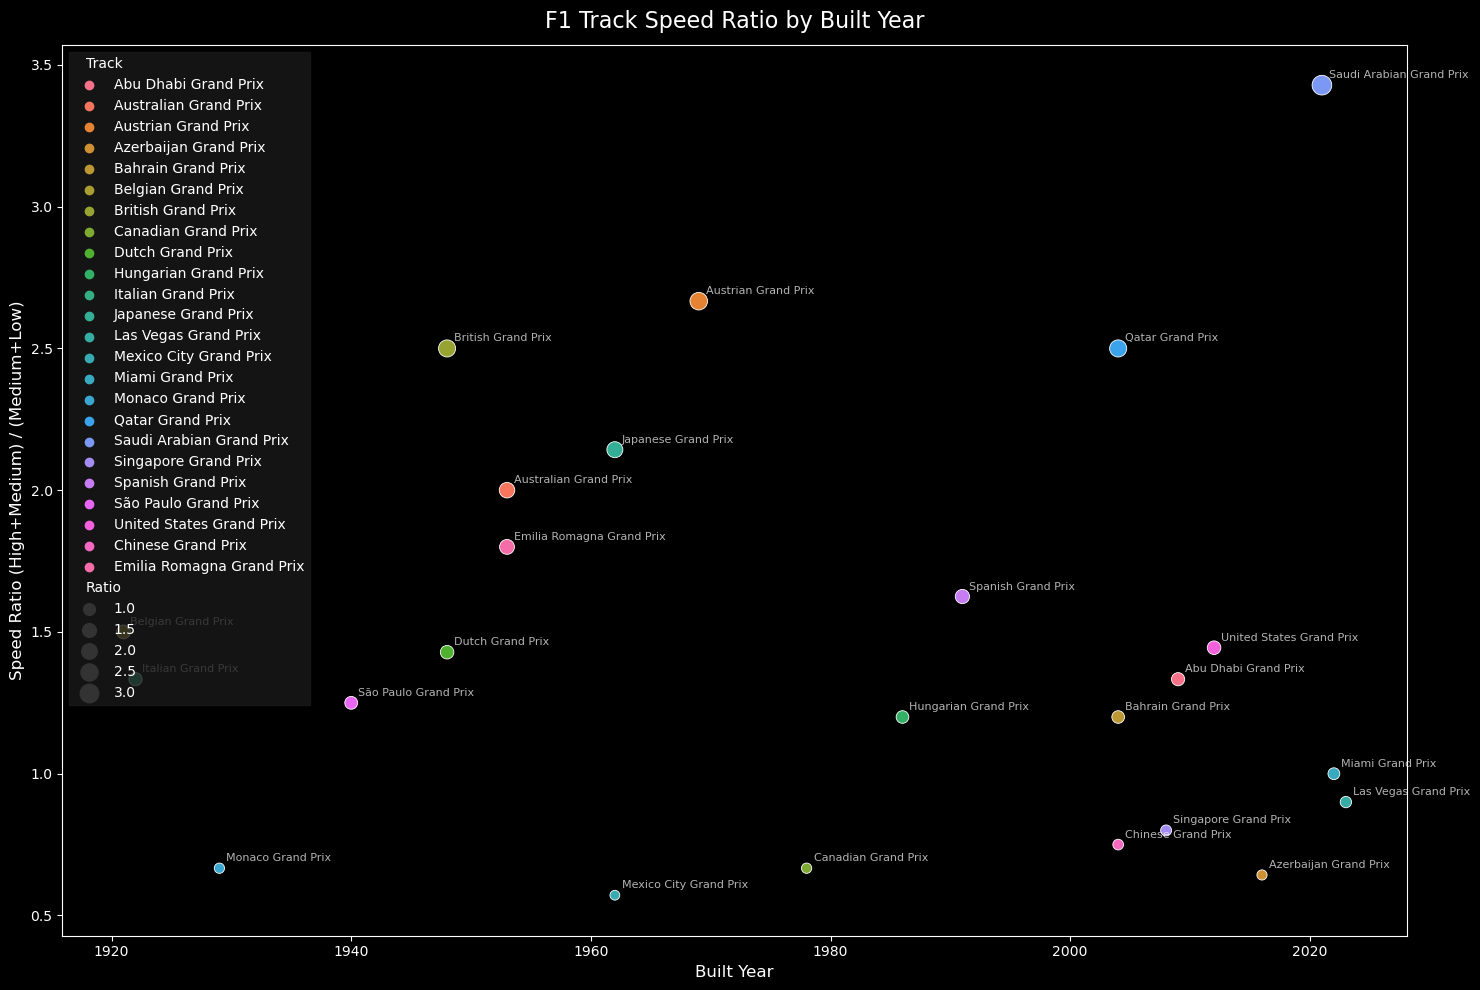


Top 5 tracks with highest speed ratio:
    built_date                     Track     Ratio
17        2021  Saudi Arabian Grand Prix  3.428571
2         1969       Austrian Grand Prix  2.666667
6         1948        British Grand Prix  2.500000
16        2004          Qatar Grand Prix  2.500000
11        1962       Japanese Grand Prix  2.142857

Top 5 tracks with lowest speed ratio:
    built_date                   Track     Ratio
13        1962  Mexico City Grand Prix  0.571429
3         2016   Azerbaijan Grand Prix  0.642857
15        1929       Monaco Grand Prix  0.666667
7         1978     Canadian Grand Prix  0.666667
22        2004      Chinese Grand Prix  0.750000


In [6]:
import seaborn as sns

# Ensure 'built_date' column is numeric
merged_data['built_date'] = pd.to_numeric(merged_data['built_date'], errors='coerce')

# Set plot style
plt.style.use('dark_background')
sns.set_palette("husl")

# Create the figure
plt.figure(figsize=(15, 10))

# Add scatter plot
scatter = sns.scatterplot(data=merged_data, x='built_date', y='Ratio', 
                          hue='Track', size='Ratio', sizes=(50, 200),
                          palette='husl', legend='brief')

# Set chart title and labels
plt.title('F1 Track Speed Ratio by Built Year', fontsize=16)
plt.xlabel('Built Year', fontsize=12)
plt.ylabel('Speed Ratio (High+Medium) / (Medium+Low)', fontsize=12)

# Add track name labels
for idx, row in merged_data.iterrows():
    plt.annotate(row['Track'], (row['built_date'], row['Ratio']),
                 xytext=(5, 5), textcoords='offset points', fontsize=8,
                 alpha=0.7, color='white')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Print some statistics
print("\nTop 5 tracks with highest speed ratio:")
print(merged_data.nlargest(5, 'Ratio')[['built_date', 'Track', 'Ratio']])
print("\nTop 5 tracks with lowest speed ratio:")
print(merged_data.nsmallest(5, 'Ratio')[['built_date', 'Track', 'Ratio']])



In this chart, we do not observe a clear correlation between track types and time based on our classification. However, we can still see that track designs have become more extreme. Several street circuits, such as Singapore, Azerbaijan, and Las Vegas, have been added. These tracks feature many low-speed corners. Additionally, we have seen tracks like Saudi Arabia, which have an extremely high proportion of high-speed corners. These tracks place greater demands on the car's top speed, corner exit traction, and mechanical grip.

# The proportion of high-, medium-, and low-speed corners for each track.

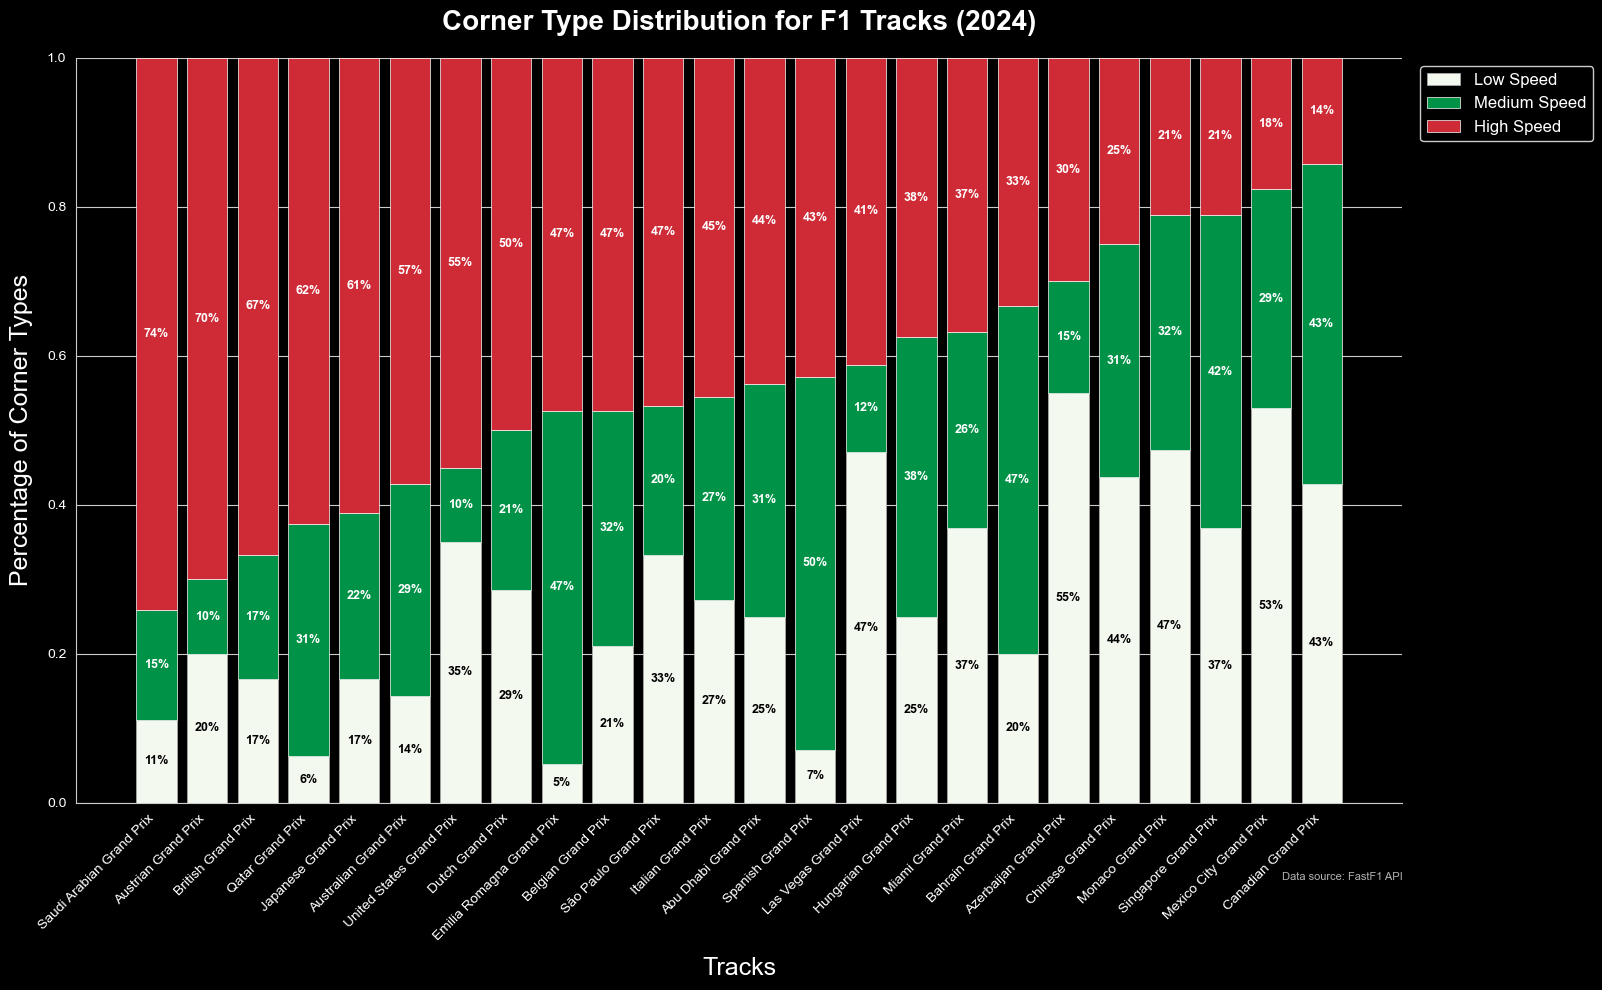


Tracks sorted by percentage of high speed corners:
                        Track   Low_Pct  Medium_Pct  High_Pct
17   Saudi Arabian Grand Prix  0.111111    0.148148  0.740741
2         Austrian Grand Prix  0.200000    0.100000  0.700000
6          British Grand Prix  0.166667    0.166667  0.666667
16           Qatar Grand Prix  0.062500    0.312500  0.625000
11        Japanese Grand Prix  0.166667    0.222222  0.611111
1       Australian Grand Prix  0.142857    0.285714  0.571429
21   United States Grand Prix  0.350000    0.100000  0.550000
8            Dutch Grand Prix  0.285714    0.214286  0.500000
23  Emilia Romagna Grand Prix  0.052632    0.473684  0.473684
5          Belgian Grand Prix  0.210526    0.315789  0.473684
20       São Paulo Grand Prix  0.333333    0.200000  0.466667
10         Italian Grand Prix  0.272727    0.272727  0.454545
0        Abu Dhabi Grand Prix  0.250000    0.312500  0.437500
19         Spanish Grand Prix  0.071429    0.500000  0.428571
12       Las Vegas

<Figure size 640x480 with 0 Axes>

In [7]:
# Read the pre-calculated percentage data
results = pd.read_csv('verstappen_2023_2024_corner_percentage.csv')

# Sort tracks by the percentage of high-speed corners
results_sorted = results.sort_values('High_Pct', ascending=False)

# Set Seaborn style
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(16, 10))

# Set the background to black
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Define the Italian flag color scheme
colors = {'Low': '#F4F9F0', 'Medium': '#009246', 'High': '#CE2B37'}

# Plot the stacked bar chart
ax.bar(results_sorted['Track'], results_sorted['Low_Pct'], label='Low Speed', color=colors['Low'], edgecolor='#B1B1B1', linewidth=0.5)
ax.bar(results_sorted['Track'], results_sorted['Medium_Pct'], bottom=results_sorted['Low_Pct'], label='Medium Speed', color=colors['Medium'], edgecolor='white', linewidth=0.5)
ax.bar(results_sorted['Track'], results_sorted['High_Pct'], bottom=results_sorted['Low_Pct']+results_sorted['Medium_Pct'], label='High Speed', color=colors['High'], edgecolor='white', linewidth=0.5)

# Set the chart title and labels
plt.title('Corner Type Distribution for F1 Tracks (2024)', fontsize=20, fontweight='bold', pad=20, color='white')
plt.xlabel('Tracks', fontsize=18, labelpad=10, color='white')
plt.ylabel('Percentage of Corner Types', fontsize=18, labelpad=10, color='white')

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right', fontsize=10, color='white')
plt.yticks(fontsize=10, color='white')

# Add a legend
legend = ax.legend(loc='upper right', fontsize=12, frameon=True, fancybox=True, framealpha=0.8, bbox_to_anchor=(1.15, 1))
legend.get_frame().set_edgecolor('white')
legend.get_frame().set_facecolor('black')
plt.setp(legend.get_texts(), color='white')

# Add percentage labels to each bar
for i, track in enumerate(results_sorted['Track']):
    low = results_sorted['Low_Pct'].iloc[i]
    medium = results_sorted['Medium_Pct'].iloc[i]
    high = results_sorted['High_Pct'].iloc[i]
    
    ax.text(i, low/2, f'{low:.0%}', ha='center', va='center', fontsize=9, fontweight='bold', color='black')
    ax.text(i, low + medium/2, f'{medium:.0%}', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    ax.text(i, low + medium + high/2, f'{high:.0%}', ha='center', va='center', fontsize=9, fontweight='bold', color='white')

# Add data source annotation
plt.annotate('Data source: FastF1 API', xy=(1, -0.1), xycoords='axes fraction', fontsize=8, ha='right', va='center', alpha=0.7, color='white')

# Set y-axis range to 0-1
ax.set_ylim(0, 1)

# Remove the top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Display the chart
plt.show()

# Save the chart
plt.savefig('f1_2023_2024_corner_type_distribution_italian_colors_black_background.png', dpi=300, bbox_inches='tight')

# Print the sorted results
print("\nTracks sorted by percentage of high speed corners:")
print(results_sorted[['Track', 'Low_Pct', 'Medium_Pct', 'High_Pct']])



# EDA 2024 data

From now on, we have completed an analysis of the track characteristics and created some interesting data visualizations. Let's start exploring the data leading up to the 14th round of the 2024 season before the Belgian Grand Prix.

### load 2024 data

In [8]:
# Enable cache to speed up data loading
ff1.Cache.enable_cache('/Users/sk_sunflower163.com/Library/Caches/fastf1')

# Set the year and session types
year = 2024
sessions = ['Q', 'R']  # Includes Qualifying and Race sessions

# Define a dictionary to store specific data objects
data_objects = {
    'session': [],
    'laps': [],
    'lap': [],
    'telemetry': [],
    'session_results': [],
    'driver_results': []
}

# All races and qualifying sessions in 2023
num_rounds = 14  # Assuming there are 14 rounds in 2024

# Use tqdm to add a progress bar to the loop
for wknd in tqdm(range(1, num_rounds + 1), desc="Loading F1 sessions"):
    for ses in sessions:
        try:
            # Load the race session
            session = ff1.get_session(year, wknd, ses)
            session.load(telemetry=True)

            # Store the Session object
            data_objects['session'].append(session)

            # Store the Laps object
            laps = session.laps
            data_objects['laps'].append(laps)

            # Store the fastest lap data
            fastest_lap = laps.pick_fastest()
            data_objects['lap'].append(fastest_lap)

            # Store Telemetry data
            telemetry = fastest_lap.get_telemetry()
            data_objects['telemetry'].append(telemetry)

            # Store SessionResults
            session_results = session.results
            data_objects['session_results'].append(session_results)

            # Store DriverResult
            driver_result = session.get_driver(driver)
            data_objects['driver_results'].append(driver_result)

        except Exception as e:
            print(f"Failed to load data for {year} round {wknd} session {ses}: {e}")

# Output data object information
for key, value in data_objects.items():
    print(f'{key}: {len(value)} items stored')

print("Data has been successfully loaded and cached.")



Loading F1 sessions:  29%|██████▌                | 4/14 [00:29<01:13,  7.40s/it]Request for URL https://ergast.com/api/f1/2024/5/results.json failed; using cached response
Traceback (most recent call last):
  File "/Users/sk_sunflower163.com/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 715, in urlopen
    httplib_response = self._make_request(
                       ^^^^^^^^^^^^^^^^^^^
  File "/Users/sk_sunflower163.com/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 467, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/sk_sunflower163.com/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py", line 462, in _make_request
    httplib_response = conn.getresponse()
                       ^^^^^^^^^^^^^^^^^^
  File "/Users/sk_sunflower163.com/anaconda3/lib/python3.11/http/client.py", line 1374, in getresponse
    response.begin()
  File "/Users/sk_sunflower163.com/anaconda3/lib/

session: 28 items stored
laps: 28 items stored
lap: 28 items stored
telemetry: 28 items stored
session_results: 28 items stored
driver_results: 28 items stored
Data has been successfully loaded and cached.


### Let's visualize and analyze the performance of each team and driver up to the 14th round of 2024.

Processing F1 Rounds: 100%|█████████████████████| 14/14 [00:47<00:00,  3.41s/it]


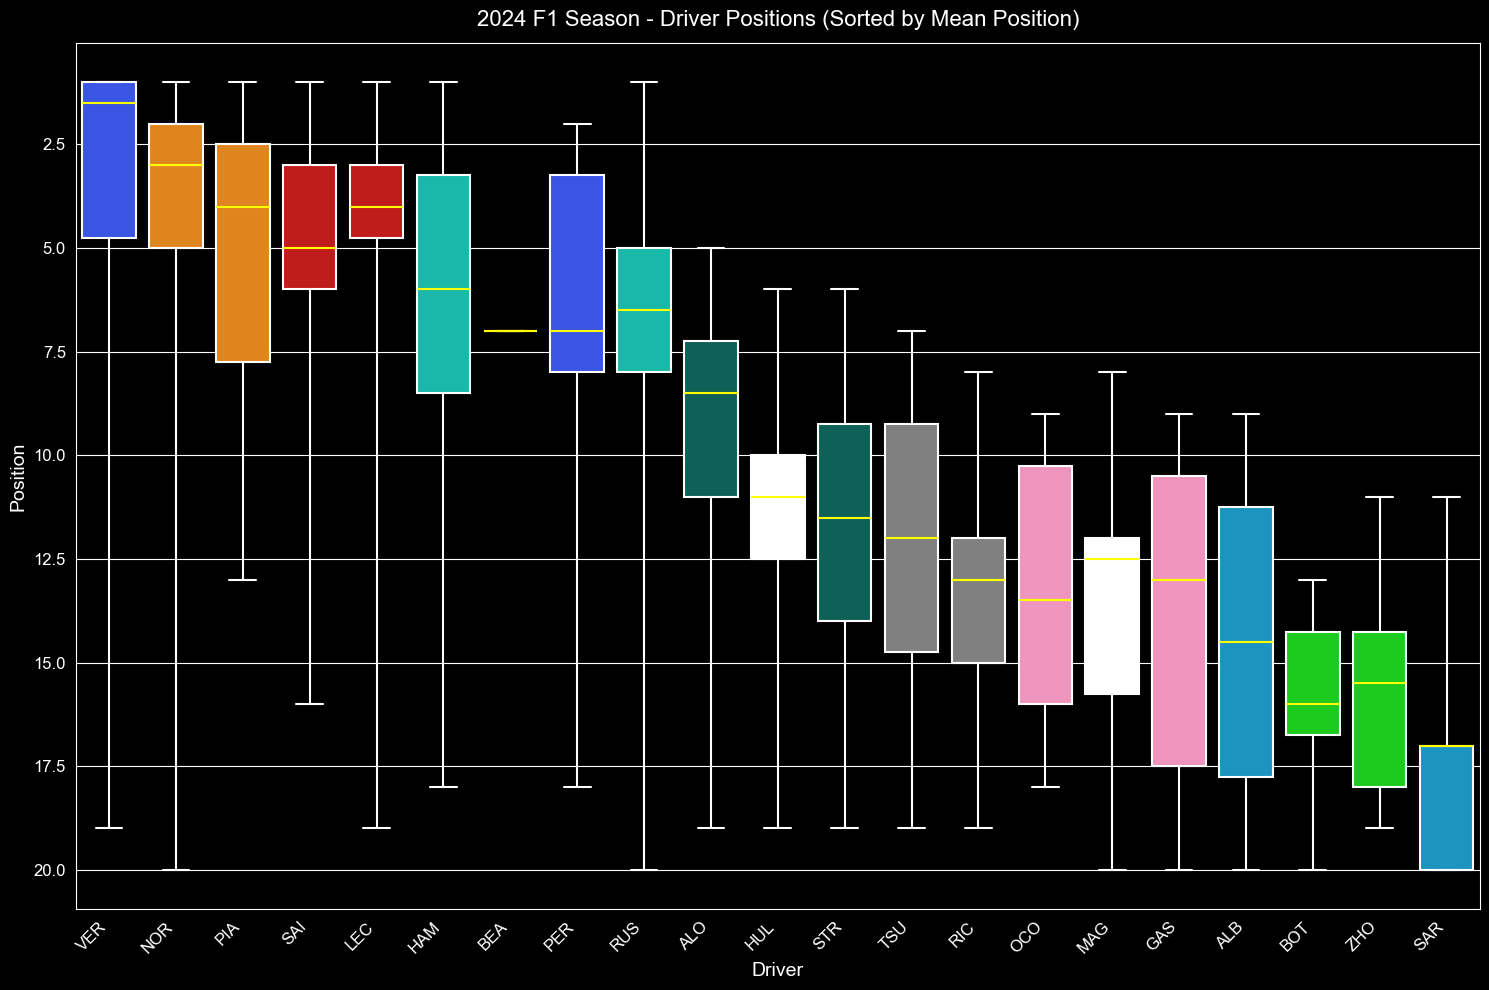

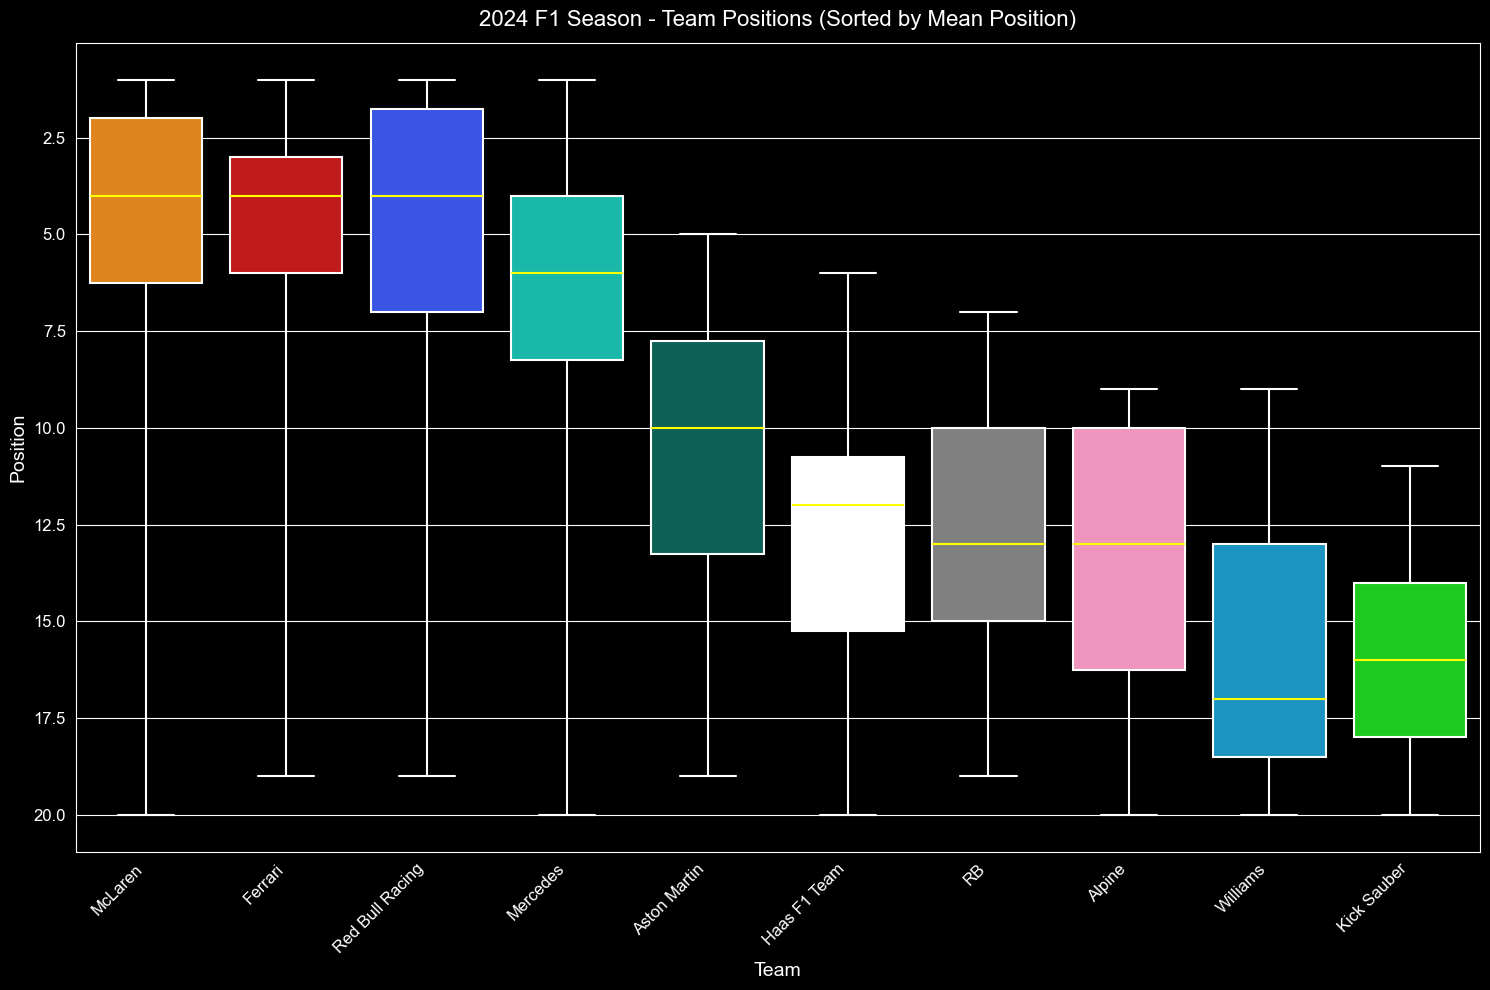

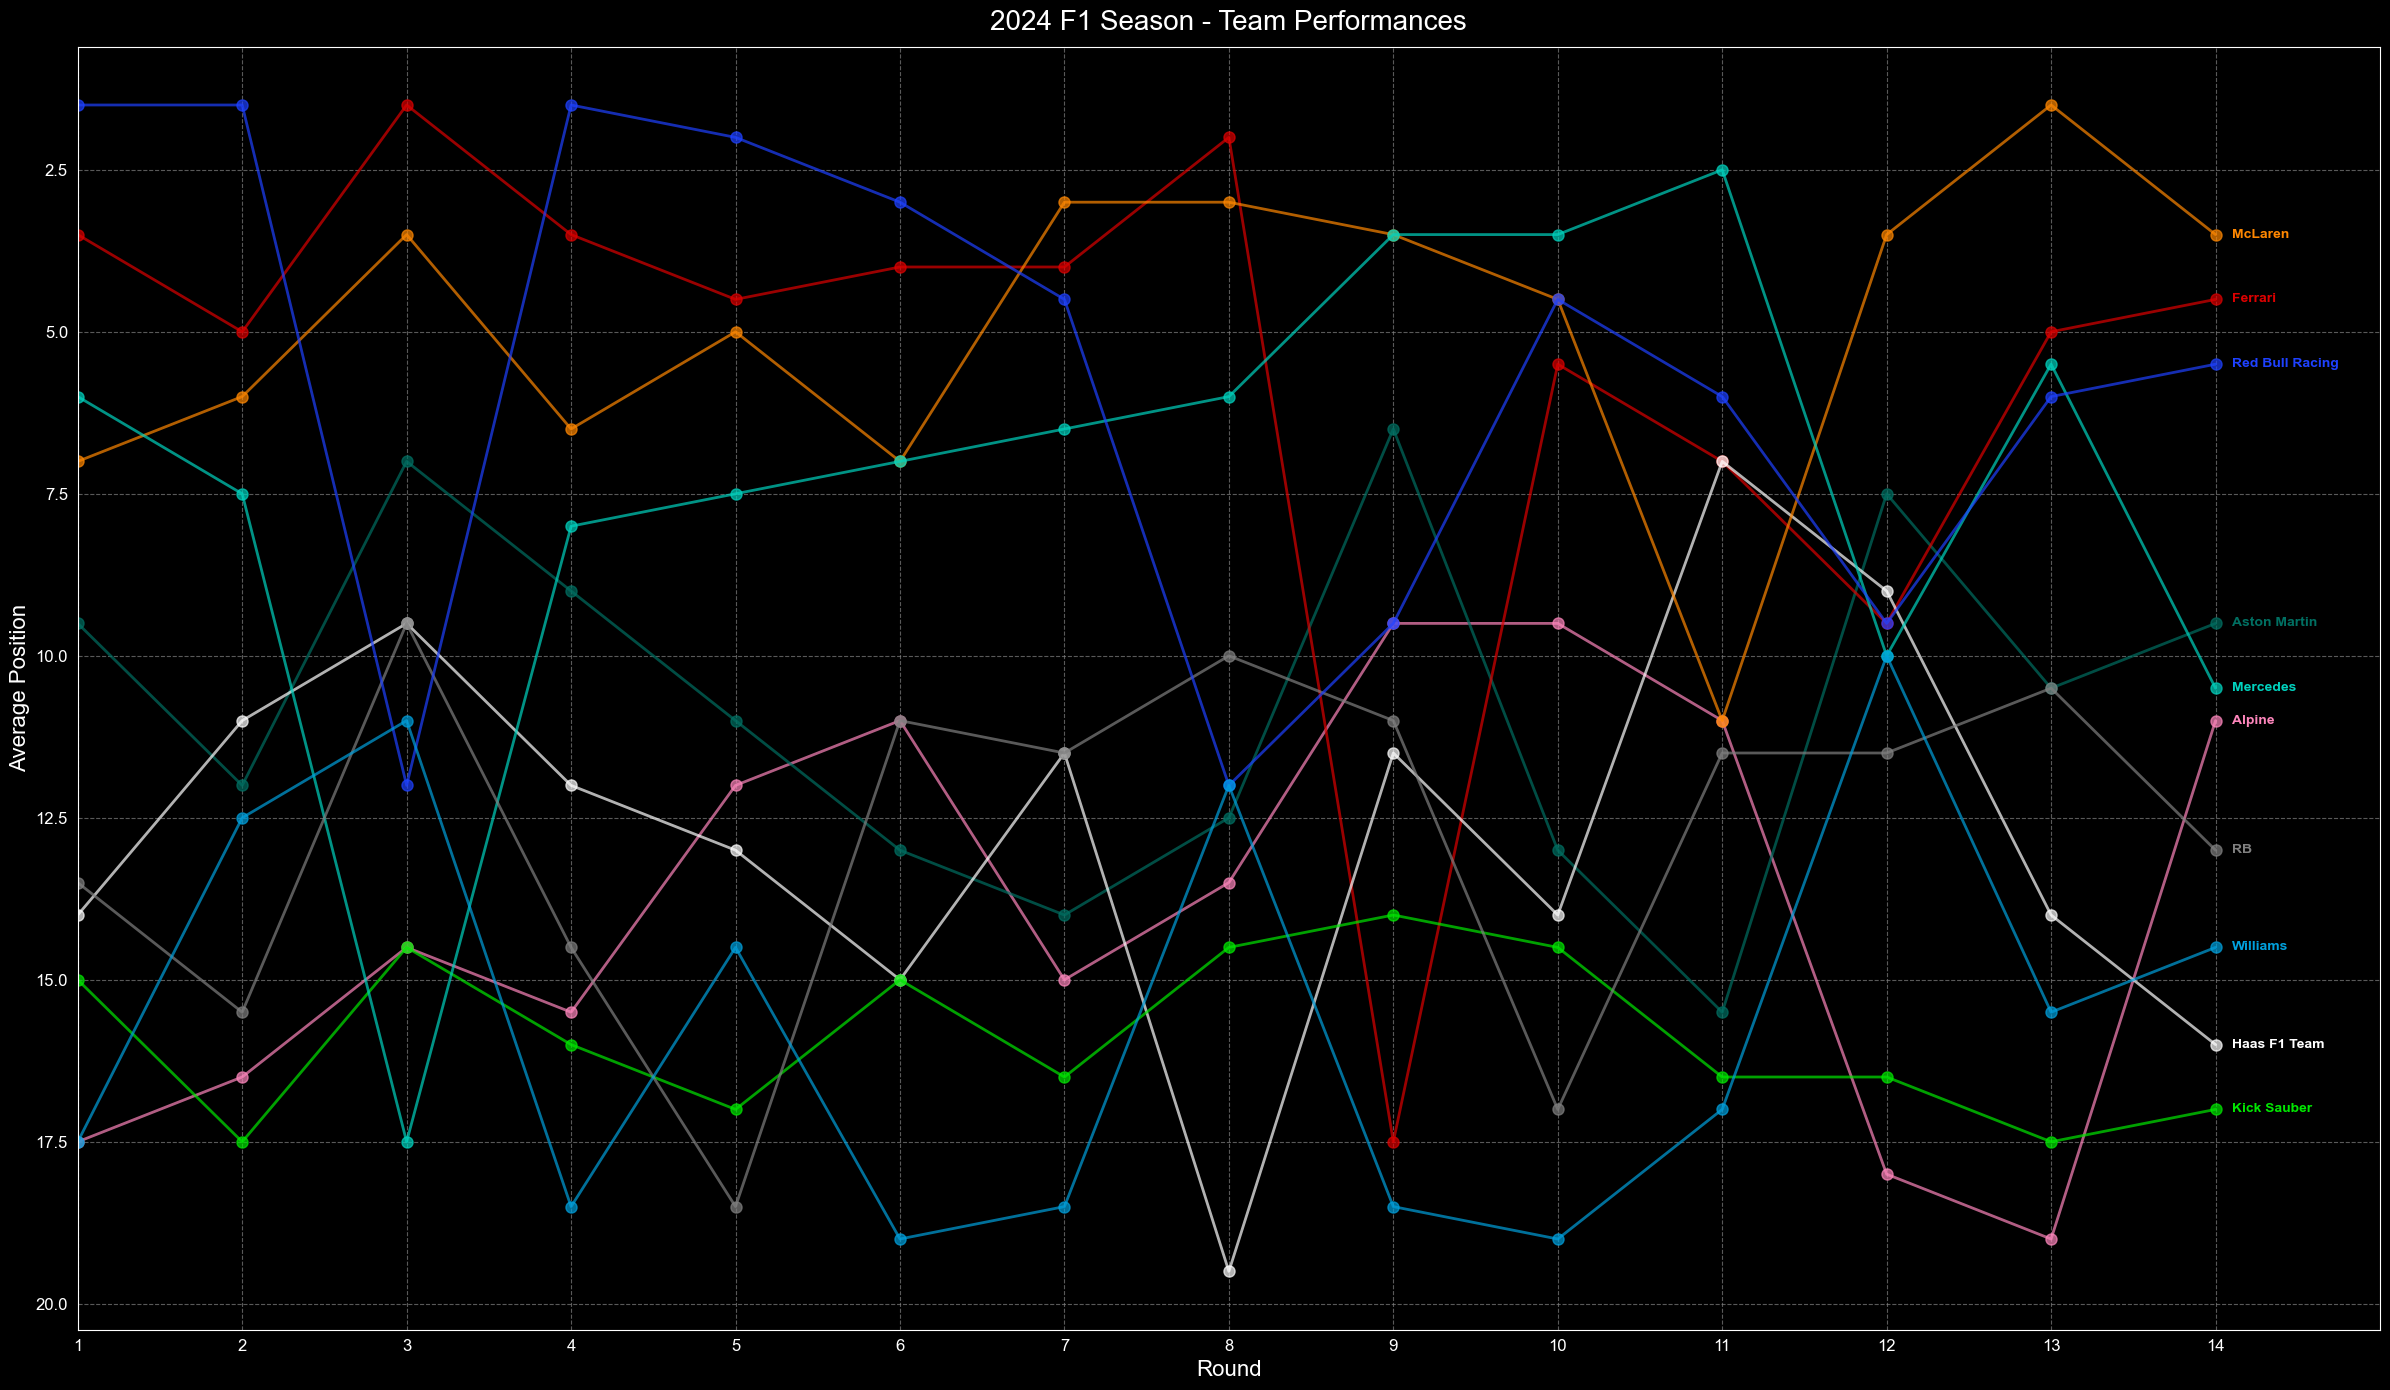

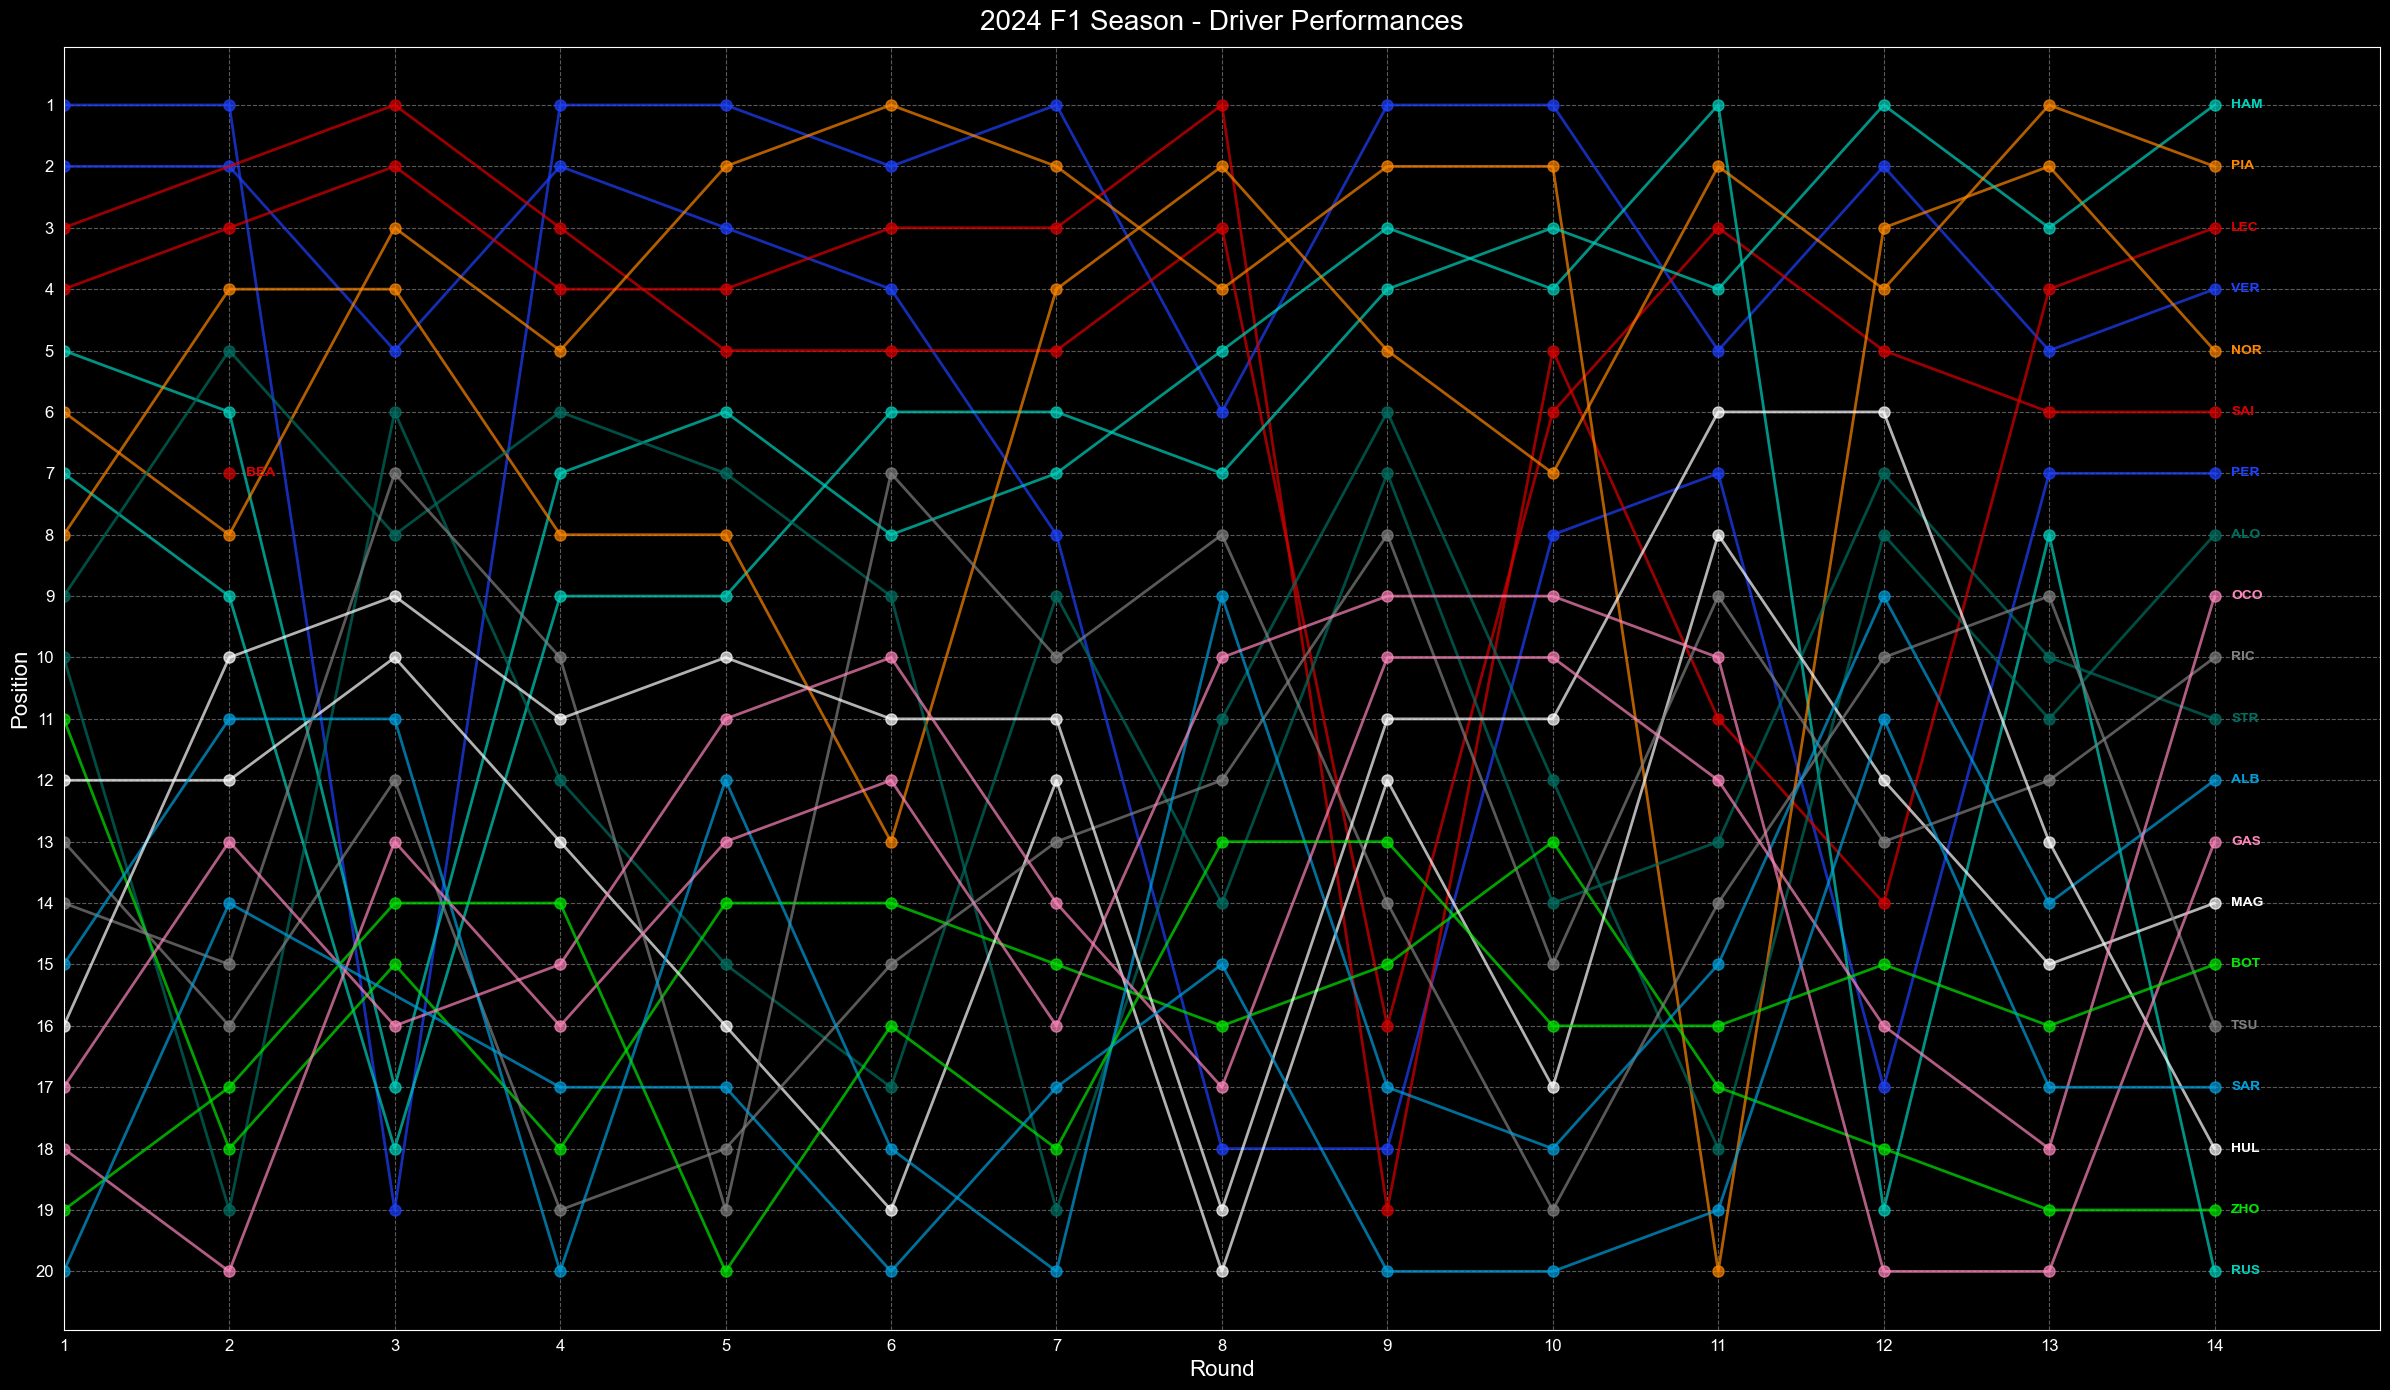


No missing data found.


In [9]:
import seaborn as sns
from tqdm import tqdm

# Enable cache to speed up data loading
ff1.Cache.enable_cache('/Users/sk_sunflower163.com/Library/Caches/fastf1')

# Set the plotting style to dark background
plt.style.use('dark_background')

# Function to get race results for a specific round
def get_race_results(year, round_number):
    session = ff1.get_session(year, round_number, 'R')
    session.load()
    results = session.results[['TeamName', 'DriverNumber', 'FullName', 'Abbreviation', 'Position']]
    results['Round'] = round_number
    return results

# Initialize empty DataFrame to collect all results
all_results = pd.DataFrame()
missing_data = []  # To track any rounds where data could not be retrieved

# Assuming 14 races have been completed in 2024
for round_number in tqdm(range(1, 15), desc="Processing F1 Rounds"):
    try:
        results = get_race_results(2024, round_number)
        all_results = pd.concat([all_results, results], ignore_index=True)
    except ff1.req.RateLimitExceededError as e:
        print(f"Rate limit exceeded while processing round {round_number}. Please try again later.")
        break
    except Exception as e:
        print(f"Error processing round {round_number}: {e}")
        missing_data.append((round_number, str(e)))  # Record missing data details

# Convert Position column to numeric, coercing errors to NaN
all_results['Position'] = pd.to_numeric(all_results['Position'], errors='coerce')

# Remove rows with missing Position data
all_results = all_results.dropna(subset=['Position'])

# Function to get team colors safely, with special cases for RB and Red Bull Racing
def get_team_color_safe(team_name):
    if team_name == 'Red Bull Racing':
        return '#1E41FF'  # Blue for Red Bull Racing
    elif team_name == 'RB':
        return '#808080'  # Gray for AlphaTauri (RB)
    try:
        return ff1.plotting.team_color(team_name)
    except KeyError:
        print(f"Warning: Color not found for team '{team_name}'. Using default color.")
        return '#000000'  # Default to black if color not found

# --------------------- DRIVER BOXPLOT --------------------- #

# Calculate mean positions for each driver
driver_mean_positions = all_results.groupby('Abbreviation')['Position'].mean()

# Sort drivers by their mean positions
driver_order = driver_mean_positions.sort_values().index.tolist()

# Map each driver to their team's color
driver_colors = [
    get_team_color_safe(
        all_results[all_results['Abbreviation'] == abbrev]['TeamName'].iloc[0]
    ) for abbrev in driver_order
]

# Create driver boxplot with a black background
plt.figure(figsize=(15, 10), facecolor='black')
sns.boxplot(
    data=all_results,
    x='Abbreviation',
    y='Position',
    order=driver_order,
    palette=driver_colors,
    whis=[0, 100],
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="yellow"),
    capprops=dict(color="white"),
    whiskerprops=dict(color="white"),
    flierprops=dict(markeredgecolor="white")
)
plt.title("2024 F1 Season - Driver Positions (Sorted by Mean Position)", fontsize=16, color='white')
plt.xlabel("Driver", fontsize=14, color='white')
plt.ylabel("Position", fontsize=14, color='white')
plt.xticks(rotation=45, ha='right', fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')
plt.gca().invert_yaxis()  # Invert y-axis so that 1 is at the top
plt.tight_layout()
plt.savefig('2024_f1_driver_positions_boxplot_sorted_by_mean_position.png', dpi=300, facecolor='black')
plt.show()

# --------------------- TEAM BOXPLOT --------------------- #

# Calculate mean positions for each team
team_mean_positions = all_results.groupby('TeamName')['Position'].mean()

# Sort teams by their mean positions
team_order = team_mean_positions.sort_values().index.tolist()

# Map each team to their color
team_colors = [get_team_color_safe(team) for team in team_order]

# Create team boxplot with a black background
plt.figure(figsize=(15, 10), facecolor='black')
sns.boxplot(
    data=all_results,
    x='TeamName',
    y='Position',
    order=team_order,
    palette=team_colors,
    whis=[0, 100],
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="yellow"),
    capprops=dict(color="white"),
    whiskerprops=dict(color="white"),
    flierprops=dict(markeredgecolor="white")
)
plt.title("2024 F1 Season - Team Positions (Sorted by Mean Position)", fontsize=16, color='white')
plt.xlabel("Team", fontsize=14, color='white')
plt.ylabel("Position", fontsize=14, color='white')
plt.xticks(rotation=45, ha='right', fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')
plt.gca().invert_yaxis()  # Invert y-axis so that 1 is at the top
plt.tight_layout()
plt.savefig('2024_f1_team_positions_boxplot_sorted_by_mean_position.png', dpi=300, facecolor='black')
plt.show()


# --------------------- TEAM PERFORMANCE LINE PLOT --------------------- #

# Calculate team performances (average position of drivers)
team_performances = all_results.groupby(['Round', 'TeamName'])['Position'].mean().unstack()

# Create team performance line plot with a black background
plt.figure(figsize=(24, 14), facecolor='black')  # Increased figure size
for team in team_performances.columns:
    line = plt.plot(team_performances.index, team_performances[team], 
             label=team, color=get_team_color_safe(team), 
             alpha=0.7, linewidth=2, marker='o', markersize=8)
    
    # Add team name at the end of the line
    last_valid = team_performances[team].dropna().iloc[-1]
    plt.text(team_performances.index[-1] + 0.1, last_valid, team, 
             color=get_team_color_safe(team), fontweight='bold', fontsize=10,
             verticalalignment='center')

plt.title("2024 F1 Season - Team Performances", fontsize=20, color='white')
plt.xlabel("Round", fontsize=16, color='white')
plt.ylabel("Average Position", fontsize=16, color='white')
plt.gca().invert_yaxis()  # Invert y-axis so that 1 is at the top
plt.grid(True, linestyle='--', alpha=0.7, color='gray')
plt.xticks(team_performances.index, fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')
plt.xlim(team_performances.index.min(), team_performances.index.max() + 1)  # Extend x-axis for labels
plt.tight_layout()
plt.savefig('2024_f1_team_performances_line_plot_enhanced.png', dpi=300, bbox_inches='tight', facecolor='black')
plt.show()

# --------------------- DRIVER PERFORMANCE LINE PLOT --------------------- #

# Create driver performance line plot with a black background
plt.figure(figsize=(24, 14), facecolor='black')  # Increased figure size
for driver in all_results['Abbreviation'].unique():
    driver_data = all_results[all_results['Abbreviation'] == driver]
    team = driver_data['TeamName'].iloc[0]  # Get the team of the driver
    line = plt.plot(driver_data['Round'], driver_data['Position'], 
             label=driver, color=get_team_color_safe(team),
             alpha=0.7, linewidth=2, marker='o', markersize=8)
    
    # Add driver abbreviation at the end of the line
    last_valid = driver_data['Position'].dropna().iloc[-1]
    plt.text(driver_data['Round'].max() + 0.1, last_valid, driver, 
             color=get_team_color_safe(team), fontweight='bold', fontsize=10,
             verticalalignment='center')

plt.title("2024 F1 Season - Driver Performances", fontsize=20, color='white')
plt.xlabel("Round", fontsize=16, color='white')
plt.ylabel("Position", fontsize=16, color='white')
plt.gca().invert_yaxis()  # Invert y-axis so that 1 is at the top
plt.grid(True, linestyle='--', alpha=0.7, color='gray')
plt.xticks(all_results['Round'].unique(), fontsize=12, color='white')
plt.yticks(range(1, int(all_results['Position'].max()) + 1), fontsize=12, color='white')  # Fixed TypeError
plt.xlim(all_results['Round'].min(), all_results['Round'].max() + 1)  # Extend x-axis for labels
plt.tight_layout()
plt.savefig('2024_f1_driver_performances_line_plot_enhanced.png', dpi=300, bbox_inches='tight', facecolor='black')
plt.show()

# --------------------- MISSING DATA SUMMARY --------------------- #

if missing_data:
    print("\nMissing Data Summary:")
    for round_number, error in missing_data:
        print(f"Round {round_number}: {error}")
else:
    print("\nNo missing data found.")


It is surprising that Ferrari's performance has been exceptionally good. Both drivers have shown remarkable consistency across the first 14 races, thanks to the stability of the 2024 Ferrari car. Due to their outstanding stability, they even rank higher than Red Bull in the boxplot. However, unfortunately, under the current F1 points system, because they have not yet shown championship-contending strength and have fewer podium finishes, they cannot compete on equal footing with Red Bull and McLaren. Red Bull, on the other hand, has been held back by Perez's inconsistent performances. While the team's overall results are not bad, Max alone cannot carry the entire team's downturn. McLaren's performance has been as expected.

# Potential Champion analysis

Let's see which teams and drivers still have a chance to compete for the championship in the final 10 races.

In [10]:
from fastf1.ergast import Ergast

SEASON = 2024
ROUND = 14  

def get_standings(type='driver'):
    ergast = Ergast()
    if type == 'driver':
        standings = ergast.get_driver_standings(season=SEASON, round=ROUND)
    else:
        standings = ergast.get_constructor_standings(season=SEASON, round=ROUND)
    return standings.content[0]

def calculate_max_points_for_remaining_season():
    POINTS_FOR_SPRINT = 8 + 25 + 1  # Sprint race win, race win, and fastest lap
    POINTS_FOR_CONVENTIONAL = 25 + 1  # Race win and fastest lap
    events = fastf1.events.get_event_schedule(SEASON, backend='ergast')
    events = events[events['RoundNumber'] > ROUND]
    sprint_events = len(events.loc[events["EventFormat"] == "sprint_shootout"])
    conventional_events = len(events.loc[events["EventFormat"] == "conventional"])
    sprint_points = sprint_events * POINTS_FOR_SPRINT
    conventional_points = conventional_events * POINTS_FOR_CONVENTIONAL
    return sprint_points + conventional_points

def calculate_who_can_win(standings, max_points, type='driver'):
    LEADER_POINTS = float(standings.loc[0]['points'])
    print(f"\nPotential {type.capitalize()} Championship Contenders:")
    for i, _ in enumerate(standings.iterrows()):
        entry = standings.loc[i]
        entry_max_points = float(entry["points"]) + max_points
        can_win = 'Yes' if entry_max_points >= LEADER_POINTS else 'No'
        if type == 'driver':
            name = f"{entry['givenName']} {entry['familyName']}"
        else:
            name = entry.get('constructorId', entry.get('name', 'Unknown Team'))
        print(f"{entry['position']}: {name}, "
              f"Current points: {entry['points']}, "
              f"Theoretical max points: {entry_max_points:.1f}, "
              f"Can win: {can_win}")

# Calculate the maximum possible points for the remaining season
max_points = calculate_max_points_for_remaining_season()

# Calculate driver championship contenders
driver_standings = get_standings('driver')
calculate_who_can_win(driver_standings, max_points, 'driver')

# Calculate constructor championship contenders
constructor_standings = get_standings('constructor')
calculate_who_can_win(constructor_standings, max_points, 'constructor')

print(f"\nNote: This calculation is based on the standings after round {ROUND} of the {SEASON} season.")
print("It assumes the current leader scores no more points and the challenger scores maximum points in all remaining races.")
print("This is a simplified calculation and does not account for tiebreakers or other complex scenarios.")



Potential Driver Championship Contenders:
1: Max Verstappen, Current points: 277.0, Theoretical max points: 459.0, Can win: Yes
2: Lando Norris, Current points: 199.0, Theoretical max points: 381.0, Can win: Yes
3: Charles Leclerc, Current points: 177.0, Theoretical max points: 359.0, Can win: Yes
4: Oscar Piastri, Current points: 167.0, Theoretical max points: 349.0, Can win: Yes
5: Carlos Sainz, Current points: 162.0, Theoretical max points: 344.0, Can win: Yes
6: Lewis Hamilton, Current points: 150.0, Theoretical max points: 332.0, Can win: Yes
7: Sergio Pérez, Current points: 131.0, Theoretical max points: 313.0, Can win: Yes
8: George Russell, Current points: 116.0, Theoretical max points: 298.0, Can win: Yes
9: Fernando Alonso, Current points: 49.0, Theoretical max points: 231.0, Can win: No
10: Lance Stroll, Current points: 24.0, Theoretical max points: 206.0, Can win: No
11: Nico Hülkenberg, Current points: 22.0, Theoretical max points: 204.0, Can win: No
12: Yuki Tsunoda, Cur

### Rank Distribution of Championship Contenders

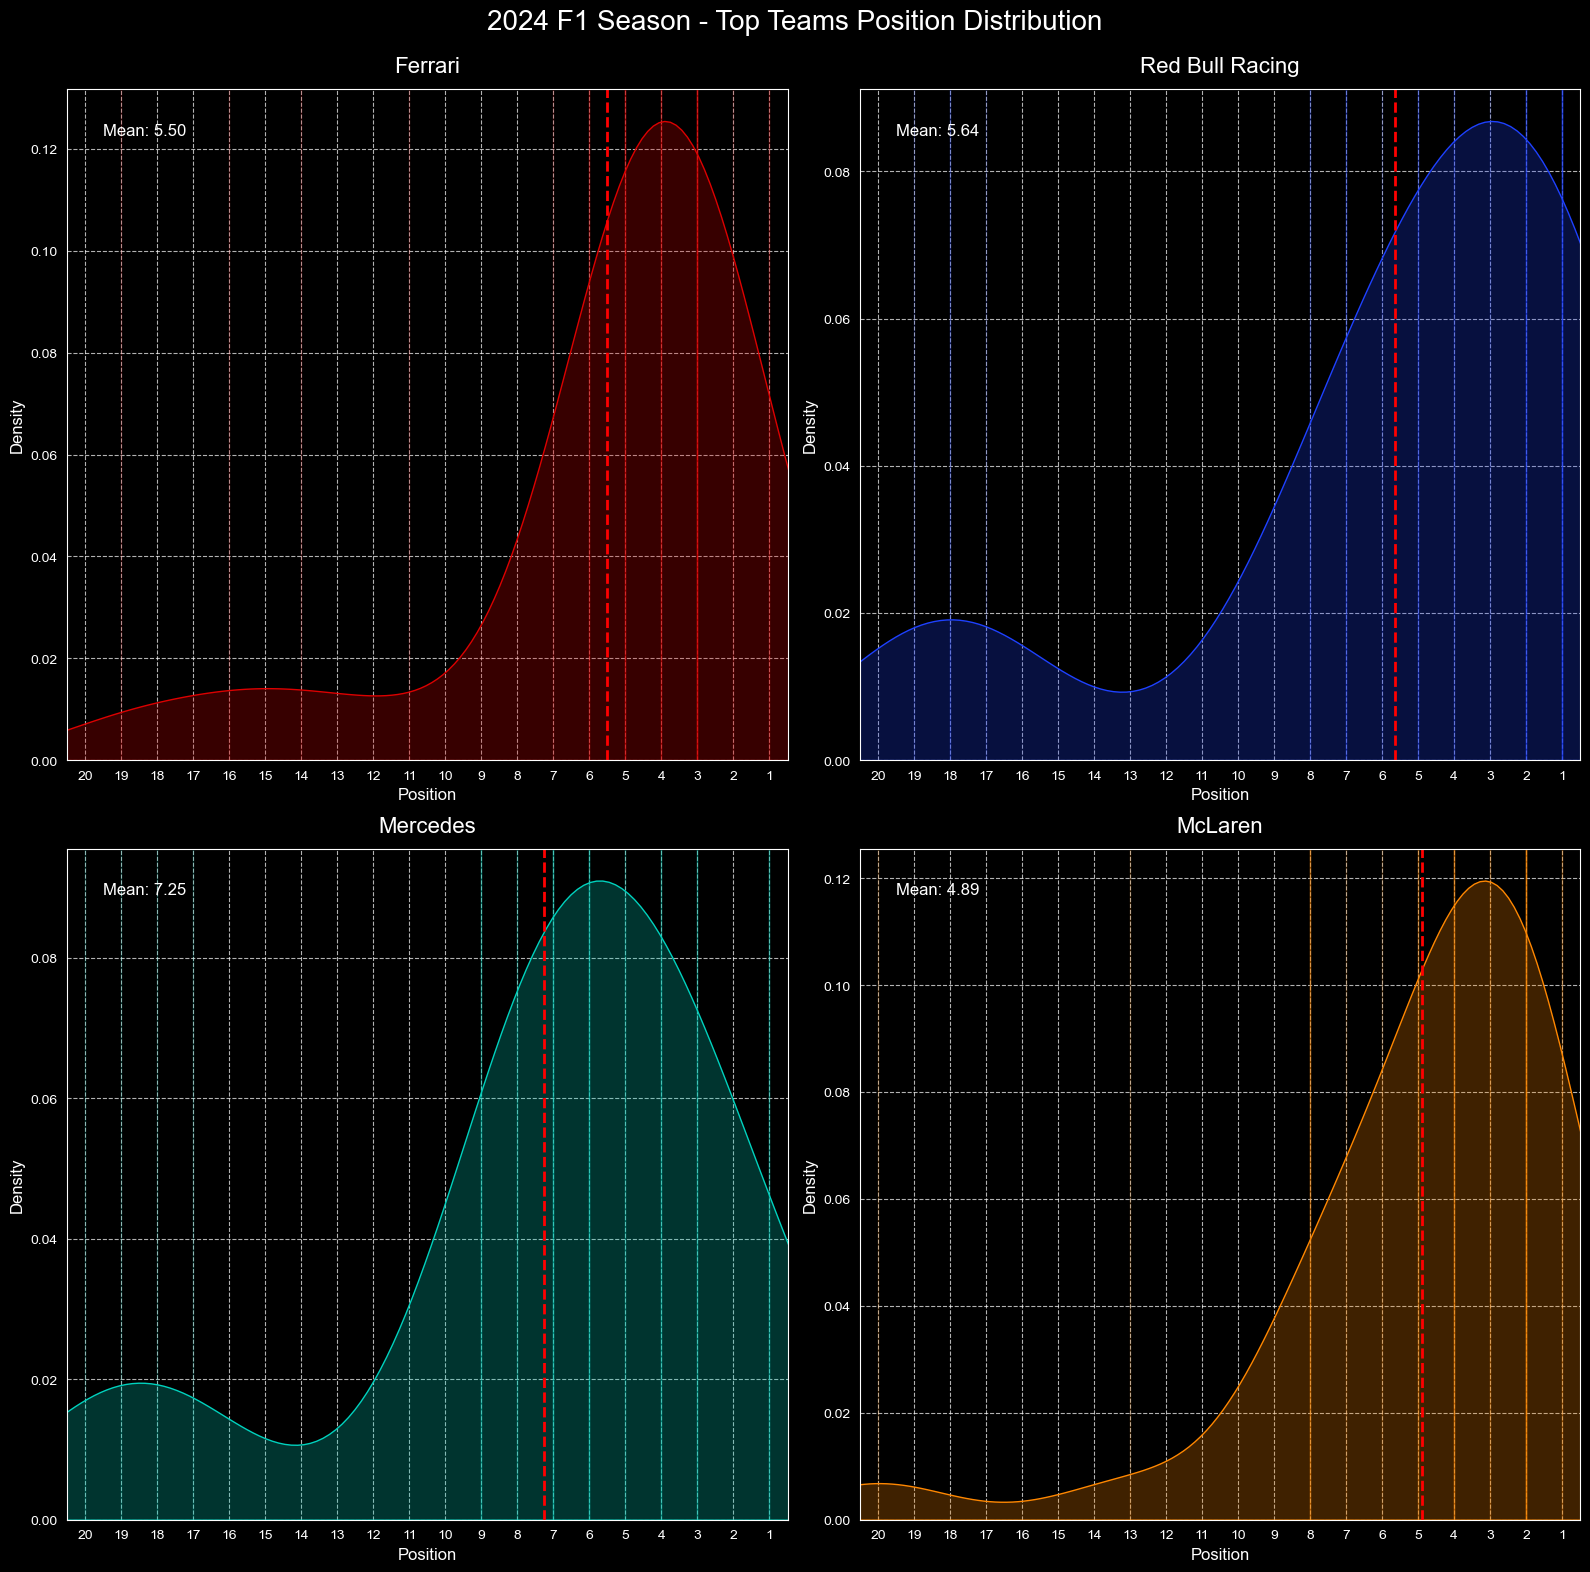


Top Teams Performance Summary:

Ferrari:
count    28.000000
mean      5.500000
std       4.350394
min       1.000000
25%       3.000000
50%       4.000000
75%       6.000000
max      19.000000
Name: Position, dtype: float64

Red Bull Racing:
count    28.000000
mean      5.642857
std       5.645151
min       1.000000
25%       1.750000
50%       4.000000
75%       7.000000
max      19.000000
Name: Position, dtype: float64

Mercedes:
count    28.000000
mean      7.250000
std       5.239628
min       1.000000
25%       4.000000
50%       6.000000
75%       8.250000
max      20.000000
Name: Position, dtype: float64

McLaren:
count    28.000000
mean      4.892857
std       4.067389
min       1.000000
25%       2.000000
50%       4.000000
75%       6.250000
max      20.000000
Name: Position, dtype: float64

Top 3 Finishes Count:
Ferrari: 11
Red Bull Racing: 13
Mercedes: 6
McLaren: 12


In [11]:
# Select the teams to compare
top_teams = ['Ferrari', 'Red Bull Racing', 'Mercedes', 'McLaren']

# Filter data for these teams
top_team_data = all_results[all_results['TeamName'].isin(top_teams)]

# Set plot style
plt.style.use('dark_background')
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
fig.suptitle("2024 F1 Season - Top Teams Position Distribution", fontsize=20)

# Flatten the axs array for easier indexing
axs = axs.ravel()

for i, team in enumerate(top_teams):
    team_data = top_team_data[top_team_data['TeamName'] == team]
    team_color = get_team_color_safe(team)
    
    # Create density plot
    sns.kdeplot(data=team_data['Position'], shade=True, color=team_color, ax=axs[i])
    
    axs[i].set_title(team, fontsize=16)
    axs[i].set_xlabel('Position', fontsize=12)
    axs[i].set_ylabel('Density', fontsize=12)
    axs[i].set_xlim(0.5, 20.5)
    axs[i].set_xticks(range(1, 21))
    axs[i].invert_xaxis()  # Invert x-axis so that 1st place is on the left
    
    # Add grid lines
    axs[i].grid(True, linestyle='--', alpha=0.7)
    
    # Calculate and display mean position
    mean_position = team_data['Position'].mean()
    axs[i].axvline(mean_position, color='red', linestyle='dashed', linewidth=2)
    axs[i].text(0.05, 0.95, f'Mean: {mean_position:.2f}', transform=axs[i].transAxes, 
                fontsize=12, verticalalignment='top', color='white')
    
    # Add specific finishing position points
    for position in team_data['Position']:
        axs[i].axvline(position, color=team_color, alpha=0.2, linewidth=1)

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Leave space for the main title

# Save the plot
plt.savefig('2024_f1_top_teams_position_distribution_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# Print a statistical summary for each top team
print("\nTop Teams Performance Summary:")
for team in top_teams:
    team_data = top_team_data[top_team_data['TeamName'] == team]
    print(f"\n{team}:")
    print(team_data['Position'].describe())

# Calculate and print the number of top 3 finishes for each team
print("\nTop 3 Finishes Count:")
for team in top_teams:
    team_data = top_team_data[top_team_data['TeamName'] == team]
    top_3_count = sum(team_data['Position'] <= 3)
    print(f"{team}: {top_3_count}")


## Momentum Analysis

Due to the continuous introduction of body part modifications and upgrades by teams throughout the season, a car's speed may progressively increase—or in some cases, decrease. By analyzing the momentum from the first 14 races, we can observe whether a team is improving or regressing in terms of speed. We plan to incorporate this analysis into our prediction model. The analysis of momentum up to round 14 is particularly important because it coincides with the start of the summer break. The summer break marks a period when teams begin to shift their focus toward developing the car for the next season rather than continuing upgrades for the current season. Therefore, the momentum observed before the 14th round could potentially indicate trends for the team's performance in the remaining season. However, it's important to note that car upgrades do not follow a linear progression. This means our momentum analysis has certain limitations—it primarily indicates a trend of improvement, but exceptions can occur. For instance, a team might make a significant leap in performance with a single upgrade after the summer break.

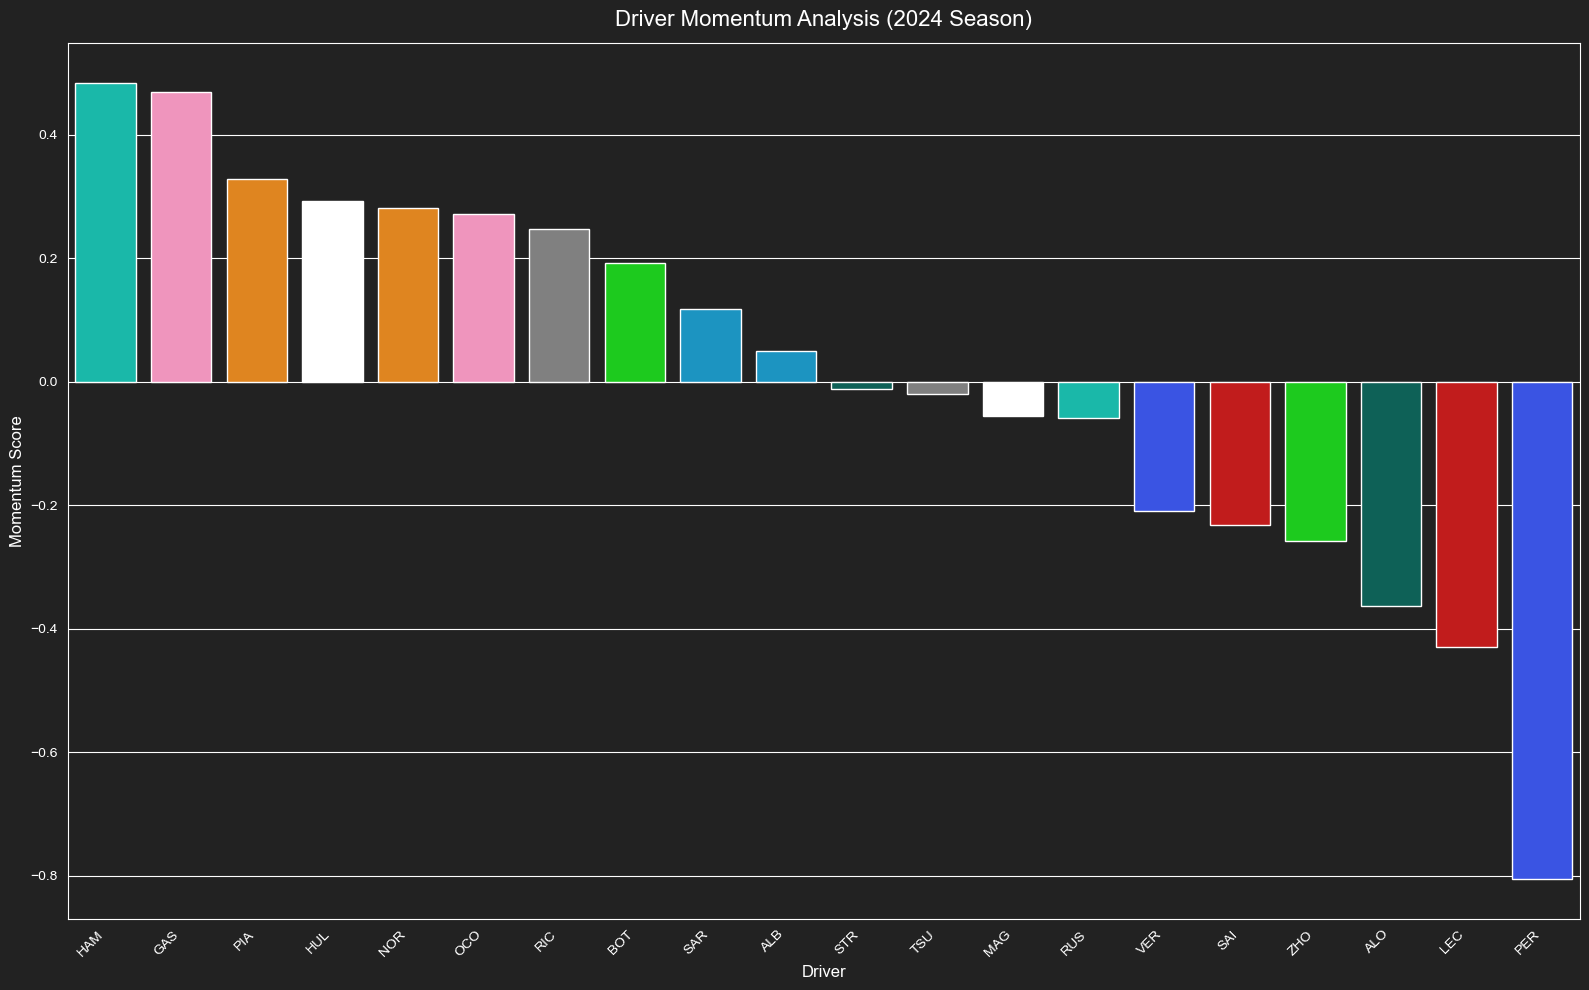

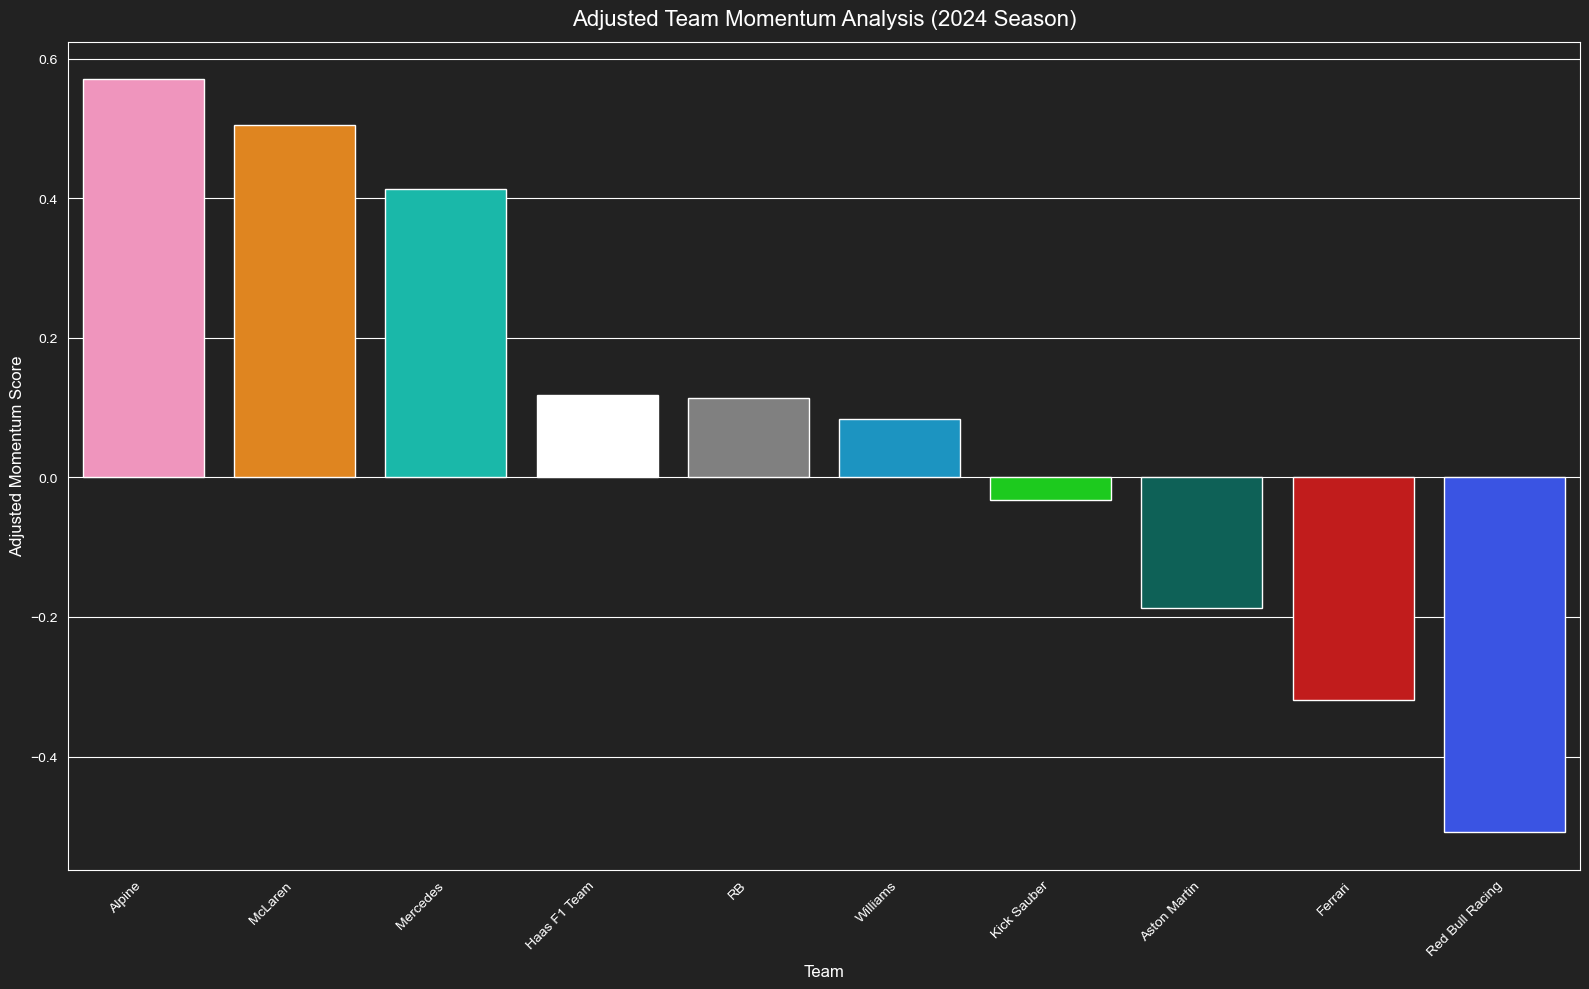


Driver Momentum Scores:
HAM: 0.48
GAS: 0.47
PIA: 0.33
HUL: 0.29
NOR: 0.28
OCO: 0.27
RIC: 0.25
BOT: 0.19
SAR: 0.12
ALB: 0.05
STR: -0.01
TSU: -0.02
MAG: -0.06
RUS: -0.06
VER: -0.21
SAI: -0.23
ZHO: -0.26
ALO: -0.36
LEC: -0.43
PER: -0.81

Adjusted Team Momentum Scores:
Alpine: 0.57
McLaren: 0.50
Mercedes: 0.41
Haas F1 Team: 0.12
RB: 0.11
Williams: 0.08
Kick Sauber: -0.03
Aston Martin: -0.19
Ferrari: -0.32
Red Bull Racing: -0.51


In [12]:
from scipy import stats

# Set plot style for dark background
plt.style.use('dark_background')
sns.set_style("darkgrid", {'axes.facecolor': '.15'})

# Read data
df = pd.read_csv('~/Desktop/2024prediction_database.csv')

# Define driver-to-team mapping
driver_team_mapping = {
    'VER': 'Red Bull Racing', 'PER': 'Red Bull Racing',
    'HAM': 'Mercedes', 'RUS': 'Mercedes',
    'LEC': 'Ferrari', 'SAI': 'Ferrari',
    'NOR': 'McLaren', 'PIA': 'McLaren',
    'ALO': 'Aston Martin', 'STR': 'Aston Martin',
    'OCO': 'Alpine', 'GAS': 'Alpine',
    'BOT': 'Kick Sauber', 'ZHO': 'Kick Sauber',
    'TSU': 'RB', 'RIC': 'RB',
    'HUL': 'Haas F1 Team', 'MAG': 'Haas F1 Team',
    'ALB': 'Williams', 'SAR': 'Williams'
}

# Define traditional strong teams
traditional_strong_teams = ['Alpine', 'Mercedes', 'Ferrari', 'Red Bull Racing', 'McLaren']

# Modified momentum calculation function
def calculate_momentum(positions, window=3):
    positions = positions.dropna()  # Remove NaN values
    if len(positions) < window:
        return 0
    smoothed_positions = positions.rolling(window=window, min_periods=1).mean()
    slope, _, _, _, _ = stats.linregress(range(len(smoothed_positions)), smoothed_positions)
    return -slope

# Method to get team color safely
def get_team_color_safe(team_name):
    if team_name == 'Red Bull Racing':
        return '#1E41FF'  # Blue for Red Bull
    elif team_name == 'RB':
        return '#808080'  # Gray for AlphaTauri (RB)
    try:
        return fastf1.plotting.team_color(team_name)
    except KeyError:
        print(f"Warning: Color not found for team '{team_name}'. Using default color.")
        return '#000000'  # Default to black

# Calculate driver momentum
driver_momentum = {}
for driver, team in driver_team_mapping.items():
    driver_positions = df[f'{driver}_Position'].dropna()
    momentum = calculate_momentum(driver_positions)
    driver_momentum[driver] = momentum

# Calculate team average positions and momentum
team_avg_positions = {}
team_momentum = {}
for team in set(driver_team_mapping.values()):
    team_drivers = [driver for driver, t in driver_team_mapping.items() if t == team]
    team_positions = df[[f'{driver}_Position' for driver in team_drivers]].mean(axis=1)
    team_avg_positions[team] = team_positions
    momentum = calculate_momentum(team_positions)
    team_momentum[team] = momentum

# Apply additional adjustments for traditional strong teams
for team in traditional_strong_teams:
    if team in team_momentum and team_momentum[team] > 0.20:
        team_momentum[team] += 0.2

# Driver momentum plot
plt.figure(figsize=(16, 10), facecolor='#222222')
ax = plt.axes()
ax.set_facecolor('#222222')
driver_momentum_sorted = sorted(driver_momentum.items(), key=lambda x: x[1], reverse=True)
sns.barplot(x=[driver for driver, _ in driver_momentum_sorted], 
            y=[momentum for _, momentum in driver_momentum_sorted],
            palette=[get_team_color_safe(driver_team_mapping[driver]) for driver, _ in driver_momentum_sorted],
            ax=ax)
plt.title(f'Driver Momentum Analysis (2024 Season)', fontsize=16, color='white')
plt.xlabel('Driver', fontsize=12, color='white')
plt.ylabel('Momentum Score', fontsize=12, color='white')
plt.xticks(rotation=45, ha='right', color='white')
plt.yticks(color='white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.tight_layout()
plt.savefig('driver_momentum_analysis_2024.png', facecolor='#222222', edgecolor='none')
plt.show()

# Team momentum plot
plt.figure(figsize=(16, 10), facecolor='#222222')
ax = plt.axes()
ax.set_facecolor('#222222')
team_momentum_sorted = sorted(team_momentum.items(), key=lambda x: x[1], reverse=True)
sns.barplot(x=[team for team, _ in team_momentum_sorted], 
            y=[momentum for _, momentum in team_momentum_sorted],
            palette=[get_team_color_safe(team) for team, _ in team_momentum_sorted],
            ax=ax)
plt.title(f'Adjusted Team Momentum Analysis (2024 Season)', fontsize=16, color='white')
plt.xlabel('Team', fontsize=12, color='white')
plt.ylabel('Adjusted Momentum Score', fontsize=12, color='white')
plt.xticks(rotation=45, ha='right', color='white')
plt.yticks(color='white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.tight_layout()
plt.savefig('adjusted_team_momentum_analysis_2024.png', facecolor='#222222', edgecolor='none')
plt.show()

print("\nDriver Momentum Scores:")
for driver, momentum in sorted(driver_momentum.items(), key=lambda x: x[1], reverse=True):
    print(f"{driver}: {momentum:.2f}")

print("\nAdjusted Team Momentum Scores:")
for team, momentum in sorted(team_momentum.items(), key=lambda x: x[1], reverse=True):
    print(f"{team}: {momentum:.2f}")


## Data preprocess

In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv('~/Desktop/2024prediction_database.csv')
print(df.head())

                      Track   Low_Pct  Medium_Pct  High_Pct  TrackLength  \
0        Bahrain Grand Prix  0.200000    0.466667  0.333333      308.238   
1  Saudi Arabian Grand Prix  0.111111    0.148148  0.740741      308.450   
2     Australian Grand Prix  0.142857    0.285714  0.571429      306.124   
3       Japanese Grand Prix  0.166667    0.222222  0.611111      307.471   
4        Chinese Grand Prix  0.437500    0.312500  0.250000      305.066   

     Track_Type  ALB_Position  ALO_Position  BEA_Position  BOT_Position  ...  \
0  Medium Speed          15.0           9.0           NaN     19.000000  ...   
1    High Speed          11.0           5.0           7.0     17.000000  ...   
2    High Speed          11.0           8.0           NaN     14.000000  ...   
3    High Speed          20.0           6.0           NaN     14.000000  ...   
4     Low Speed          12.0           7.0           NaN     15.561224  ...   

   PER_Avg_Position  PIA_Avg_Position  RIC_Avg_Position  RUS_A

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Perform One-Hot Encoding on the Track_Type column
track_type_encoder = OneHotEncoder(sparse=False)
track_type_encoded = track_type_encoder.fit_transform(df[['Track_Type']])
track_type_columns = track_type_encoder.get_feature_names_out(['Track_Type'])

# Add the encoded results back to the original DataFrame
df = pd.concat([df, pd.DataFrame(track_type_encoded, columns=track_type_columns)], axis=1)

# Drop the original Track_Type column
df = df.drop(['Track_Type'], axis=1)

# Fill missing values for the first 14 races with the average value
numeric_columns = df.select_dtypes(include=[np.number]).columns
df.iloc[:14, df.columns.get_indexer(numeric_columns)] = df.iloc[:14, df.columns.get_indexer(numeric_columns)].fillna(df.iloc[:14, df.columns.get_indexer(numeric_columns)].mean())

# Find and drop columns containing 'BEA'
df = df.drop(columns=df.columns[df.columns.str.contains('BEA')])

# Print the processed DataFrame
print("Processed DataFrame:")
print(df.head())
# Check for any remaining missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Save the processed DataFrame to a new CSV file
df.to_csv('processed_f1_data.csv', index=False)
print("\nProcessed data saved to 'processed_f1_data.csv'")


Processed DataFrame:
                      Track   Low_Pct  Medium_Pct  High_Pct  TrackLength  \
0        Bahrain Grand Prix  0.200000    0.466667  0.333333      308.238   
1  Saudi Arabian Grand Prix  0.111111    0.148148  0.740741      308.450   
2     Australian Grand Prix  0.142857    0.285714  0.571429      306.124   
3       Japanese Grand Prix  0.166667    0.222222  0.611111      307.471   
4        Chinese Grand Prix  0.437500    0.312500  0.250000      305.066   

   ALB_Position  ALO_Position  BOT_Position  GAS_Position  HAM_Position  ...  \
0          15.0           9.0     19.000000          18.0      7.000000  ...   
1          11.0           5.0     17.000000          20.0      9.000000  ...   
2          11.0           8.0     14.000000          13.0      5.372449  ...   
3          20.0           6.0     14.000000          16.0      9.000000  ...   
4          12.0           7.0     15.561224          13.0      9.000000  ...   

   RUS_Avg_Position  SAI_Avg_Position  SA

# Modeling and Prediction

In [15]:
from sklearn.linear_model import LinearRegression
import random

random.seed(42)
np.random.seed(42)

# Create driver-to-team mapping
driver_team_mapping = {
    'ALO': 'Aston Martin', 'STR': 'Aston Martin',
    'LEC': 'Ferrari', 'SAI': 'Ferrari',
    'HAM': 'Mercedes', 'RUS': 'Mercedes',
    'NOR': 'McLaren', 'PIA': 'McLaren',
    'VER': 'Red Bull Racing', 'PER': 'Red Bull Racing',
    'ALB': 'Williams', 'SAR': 'Williams',
    'BOT': 'Kick Sauber', 'ZHO': 'Kick Sauber',
    'GAS': 'Alpine', 'OCO': 'Alpine',
    'MAG': 'Haas F1 Team', 'HUL': 'Haas F1 Team',
    'TSU': 'RB', 'RIC': 'RB'
}

# Prepare features and target variables
base_features = ['Track_Type_High Speed', 'Track_Type_Low Speed', 'Track_Type_Medium Speed']
drivers = [col.split('_')[0] for col in df.columns if col.endswith('_Position')]

# Split the dataset
train_data = df.iloc[:14]
test_data = df.iloc[14:]

# Calculate the historical volatility for each driver
driver_volatility = {driver: train_data[f'{driver}_Position'].std() for driver in drivers}

# Train models and make predictions
predictions = {}
for driver in drivers:
    features = base_features
    X_train = train_data[features]
    y_train = train_data[f'{driver}_Position']
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    X_test = test_data[features]
    predictions[driver] = model.predict(X_test)

# Apply momentum adjustments
team_momentum = {
    'Williams': 0.08,
    'Aston Martin': -0.19,
    'Ferrari': -0.32,
    'Kick Sauber': -0.03,
    'Alpine': 0.57,
    'Mercedes': 0.41,
    'Haas F1 Team': 0.12,
    'McLaren': 0.50,
    'Red Bull Racing': -0.51,
    'RB': 0.11
} #adjusted

''' 
    'Williams': -0.21,
    'Aston Martin': -0.45,
    'Ferrari': -0.40,
    'Kick Sauber': 0.00,
    'Alpine': 0.61,
    'Mercedes': 0.45,
    'Haas F1 Team': 0.30,
    'McLaren': 0.49,
    'Red Bull Racing': -0.60,
    'RB': 0.30
    
Alpine: 0.57
McLaren: 0.50
Mercedes: 0.21
Haas F1 Team: 0.12
RB: 0.11
Williams: 0.08
Kick Sauber: -0.03
Aston Martin: -0.19
Ferrari: -0.32
Red Bull Racing: -0.51

'''

# Modification: Use a normal distribution instead of a uniform distribution
# Define big teams list
big_teams = ['Aston Martin', 'Ferrari', 'Mercedes', 'Red Bull Racing', 'McLaren']

# Set scale factors for big teams and small teams
big_team_scale_factor = 0.3
small_team_scale_factor = 0.6  # Smaller teams have higher randomness

for driver, pred in predictions.items():
    team = driver_team_mapping[driver]
    momentum = team_momentum[team]
    
    # Select scale factor based on the team
    if team in big_teams:
        scale_factor = big_team_scale_factor
    else:
        scale_factor = small_team_scale_factor
    
    volatility = driver_volatility[driver] * scale_factor
    
    # Add random fluctuation to each race
    random_factor = np.random.normal(0, volatility / 2, len(pred))  # Use volatility/2 as standard deviation
    
    predictions[driver] = pred - momentum + random_factor

# Convert to actual rankings
final_rankings = pd.DataFrame(index=test_data.index, columns=drivers)
for i in range(len(test_data)):
    race_predictions = {driver: predictions[driver][i] for driver in drivers}
    sorted_drivers = sorted(race_predictions, key=race_predictions.get)
    for rank, driver in enumerate(sorted_drivers, 1):
        final_rankings.loc[test_data.index[i], driver] = rank

# Combine results
result_df = pd.concat([test_data[['Track']], final_rankings], axis=1)
result_df = result_df.iloc[:, :21]

# Print the trimmed DataFrame
print("\nTrimmed DataFrame (first 20 columns):")
print(result_df)

# Save the trimmed results
result_df.to_csv('f1_2024_predictions_trimmed.csv', index=False)
print("\nTrimmed predictions saved to 'f1_2024_predictions_trimmed.csv'")

# Model coefficient analysis
coefficients = {}
for driver in drivers:
    features = base_features
    model = LinearRegression().fit(train_data[features], train_data[f'{driver}_Position'])
    coefficients[driver] = pd.Series(model.coef_, index=features)
coefficients_df = pd.DataFrame(coefficients)
print("\nModel Coefficients:")
print(coefficients_df)

# Save the coefficient analysis results
coefficients_df.to_csv('f1_2024_model_coefficients_with_dnf_v2.csv')
print("\nModel coefficients saved to 'f1_2024_model_coefficients_with_dnf_v2.csv'")


Trimmed DataFrame (first 20 columns):
                       Track ALB ALO BOT GAS HAM HUL LEC MAG NOR  ... PER PIA  \
14          Dutch Grand Prix  17   9  19  16   5  11   6  13   3  ...   7   1   
15        Italian Grand Prix  15   8  17  18   5  10   6  14   3  ...   7   2   
16     Azerbaijan Grand Prix  17   9  16  12   7  10   3  18   1  ...   8   6   
17      Singapore Grand Prix  18   8  16  10   7  13   2  19   1  ...   9   5   
18  United States Grand Prix  17   9  19  18   3  15   6  11   1  ...   8   5   
19    Mexico City Grand Prix  15   8  16  10   6  13   3  19   1  ...   9   4   
20      São Paulo Grand Prix  17   8  18  16   5  10   6  13   4  ...   9   2   
21      Las Vegas Grand Prix  18   9  16   8   7  11   4  17   1  ...  10   3   
22          Qatar Grand Prix  16   8  19  15   5  11   6  13   2  ...   7   3   
23      Abu Dhabi Grand Prix  17   9  19  16   3  15   4  13   2  ...   8   6   

   RIC RUS SAI SAR STR TSU VER ZHO  
14  14   8   4  18  10  12   2  

# Prediction

### Load Sprint Results

In [16]:
# Set season and round number
season = 2024
round_number = 14

# Create a manual mapping between driver numbers and abbreviations
driver_number_to_abbreviation = {
    '1': 'VER',   # Max Verstappen
    '44': 'HAM',  # Lewis Hamilton
    '11': 'PER',  # Sergio Perez
    '16': 'LEC',  # Charles Leclerc
    '55': 'SAI',  # Carlos Sainz
    '4': 'NOR',   # Lando Norris
    '81': 'PIA',  # Oscar Piastri
    '63': 'RUS',  # George Russell
    '24': 'ZHO',  # Zhou Guanyu
    '20': 'MAG',  # Kevin Magnussen
    '3': 'RIC',   # Daniel Ricciardo
    '77': 'BOT',  # Valtteri Bottas
    '31': 'OCO',  # Esteban Ocon
    '18': 'STR',  # Lance Stroll
    '10': 'GAS',  # Pierre Gasly
    '22': 'TSU',  # Yuki Tsunoda
    '23': 'ALB',  # Alex Albon
    '2': 'SAR',   # Logan Sargeant
    '27': 'HUL',  # Nico Hulkenberg
    '14': 'ALO'   # Fernando Alonso
}

# F1 Sprint points system
sprint_points_system = {1: 8, 2: 7, 3: 6, 4: 5, 5: 4, 6: 3, 7: 2, 8: 1}

# DataFrame to store results
sprint_results_df = pd.DataFrame(columns=['Round', 'Driver', 'SprintPoints'])

# Retrieve and load Sprint session data for each round
for round_num in tqdm(range(1, round_number + 1), desc="Loading Sprint sessions"):
    try:
        sprint_session = fastf1.get_session(season, round_num, 'S')
        sprint_session.load()
        
        # Get Sprint race results
        sprint_results = sprint_session.results[['DriverNumber', 'Position']]
        
        # Calculate points based on driver number and convert to abbreviation
        temp_df = pd.DataFrame()
        for _, row in sprint_results.iterrows():
            driver_number = str(row['DriverNumber'])
            driver_abbreviation = driver_number_to_abbreviation.get(driver_number, 'Unknown')
            position = row['Position']
            points = sprint_points_system.get(position, 0)
            
            temp_df = pd.concat([temp_df, pd.DataFrame({
                'Round': [round_num],
                'Driver': [driver_abbreviation],
                'SprintPoints': [points]
            })])
        
        sprint_results_df = pd.concat([sprint_results_df, temp_df], ignore_index=True)
        
    except Exception as e:
        print(f"Unable to load Sprint data for Round {round_num}: {e}")

# Print the Sprint race points summary for each round
print(sprint_results_df)




Loading Sprint sessions:   0%|                           | 0/14 [00:00<?, ?it/s]

Unable to load Sprint data for Round 1: Session type 'S' does not exist for this event
Unable to load Sprint data for Round 2: Session type 'S' does not exist for this event
Unable to load Sprint data for Round 3: Session type 'S' does not exist for this event
Unable to load Sprint data for Round 4: Session type 'S' does not exist for this event


Loading Sprint sessions:  43%|████████▏          | 6/14 [00:08<00:12,  1.55s/it]

Unable to load Sprint data for Round 7: Session type 'S' does not exist for this event
Unable to load Sprint data for Round 8: Session type 'S' does not exist for this event
Unable to load Sprint data for Round 9: Session type 'S' does not exist for this event
Unable to load Sprint data for Round 10: Session type 'S' does not exist for this event


Loading Sprint sessions: 100%|██████████████████| 14/14 [00:10<00:00,  1.29it/s]

Unable to load Sprint data for Round 12: Session type 'S' does not exist for this event
Unable to load Sprint data for Round 13: Session type 'S' does not exist for this event
Unable to load Sprint data for Round 14: Session type 'S' does not exist for this event
   Round Driver SprintPoints
0      5    VER            8
1      5    HAM            7
2      5    PER            6
3      5    LEC            5
4      5    SAI            4
5      5    NOR            3
6      5    PIA            2
7      5    RUS            1
8      5    ZHO            0
9      5    MAG            0
10     5    RIC            0
11     5    BOT            0
12     5    OCO            0
13     5    STR            0
14     5    GAS            0
15     5    TSU            0
16     5    ALB            0
17     5    SAR            0
18     5    HUL            0
19     5    ALO            0
20     6    VER            8
21     6    LEC            7
22     6    PER            6
23     6    RIC            5
24     6   

### Plot Prediction

Processing Race Data: 100%|████████████████████| 14/14 [00:00<00:00, 114.88it/s]


Starting Driver Points Plot...


Plotting Driver Points: 100%|██████████████████| 21/21 [00:00<00:00, 579.43it/s]


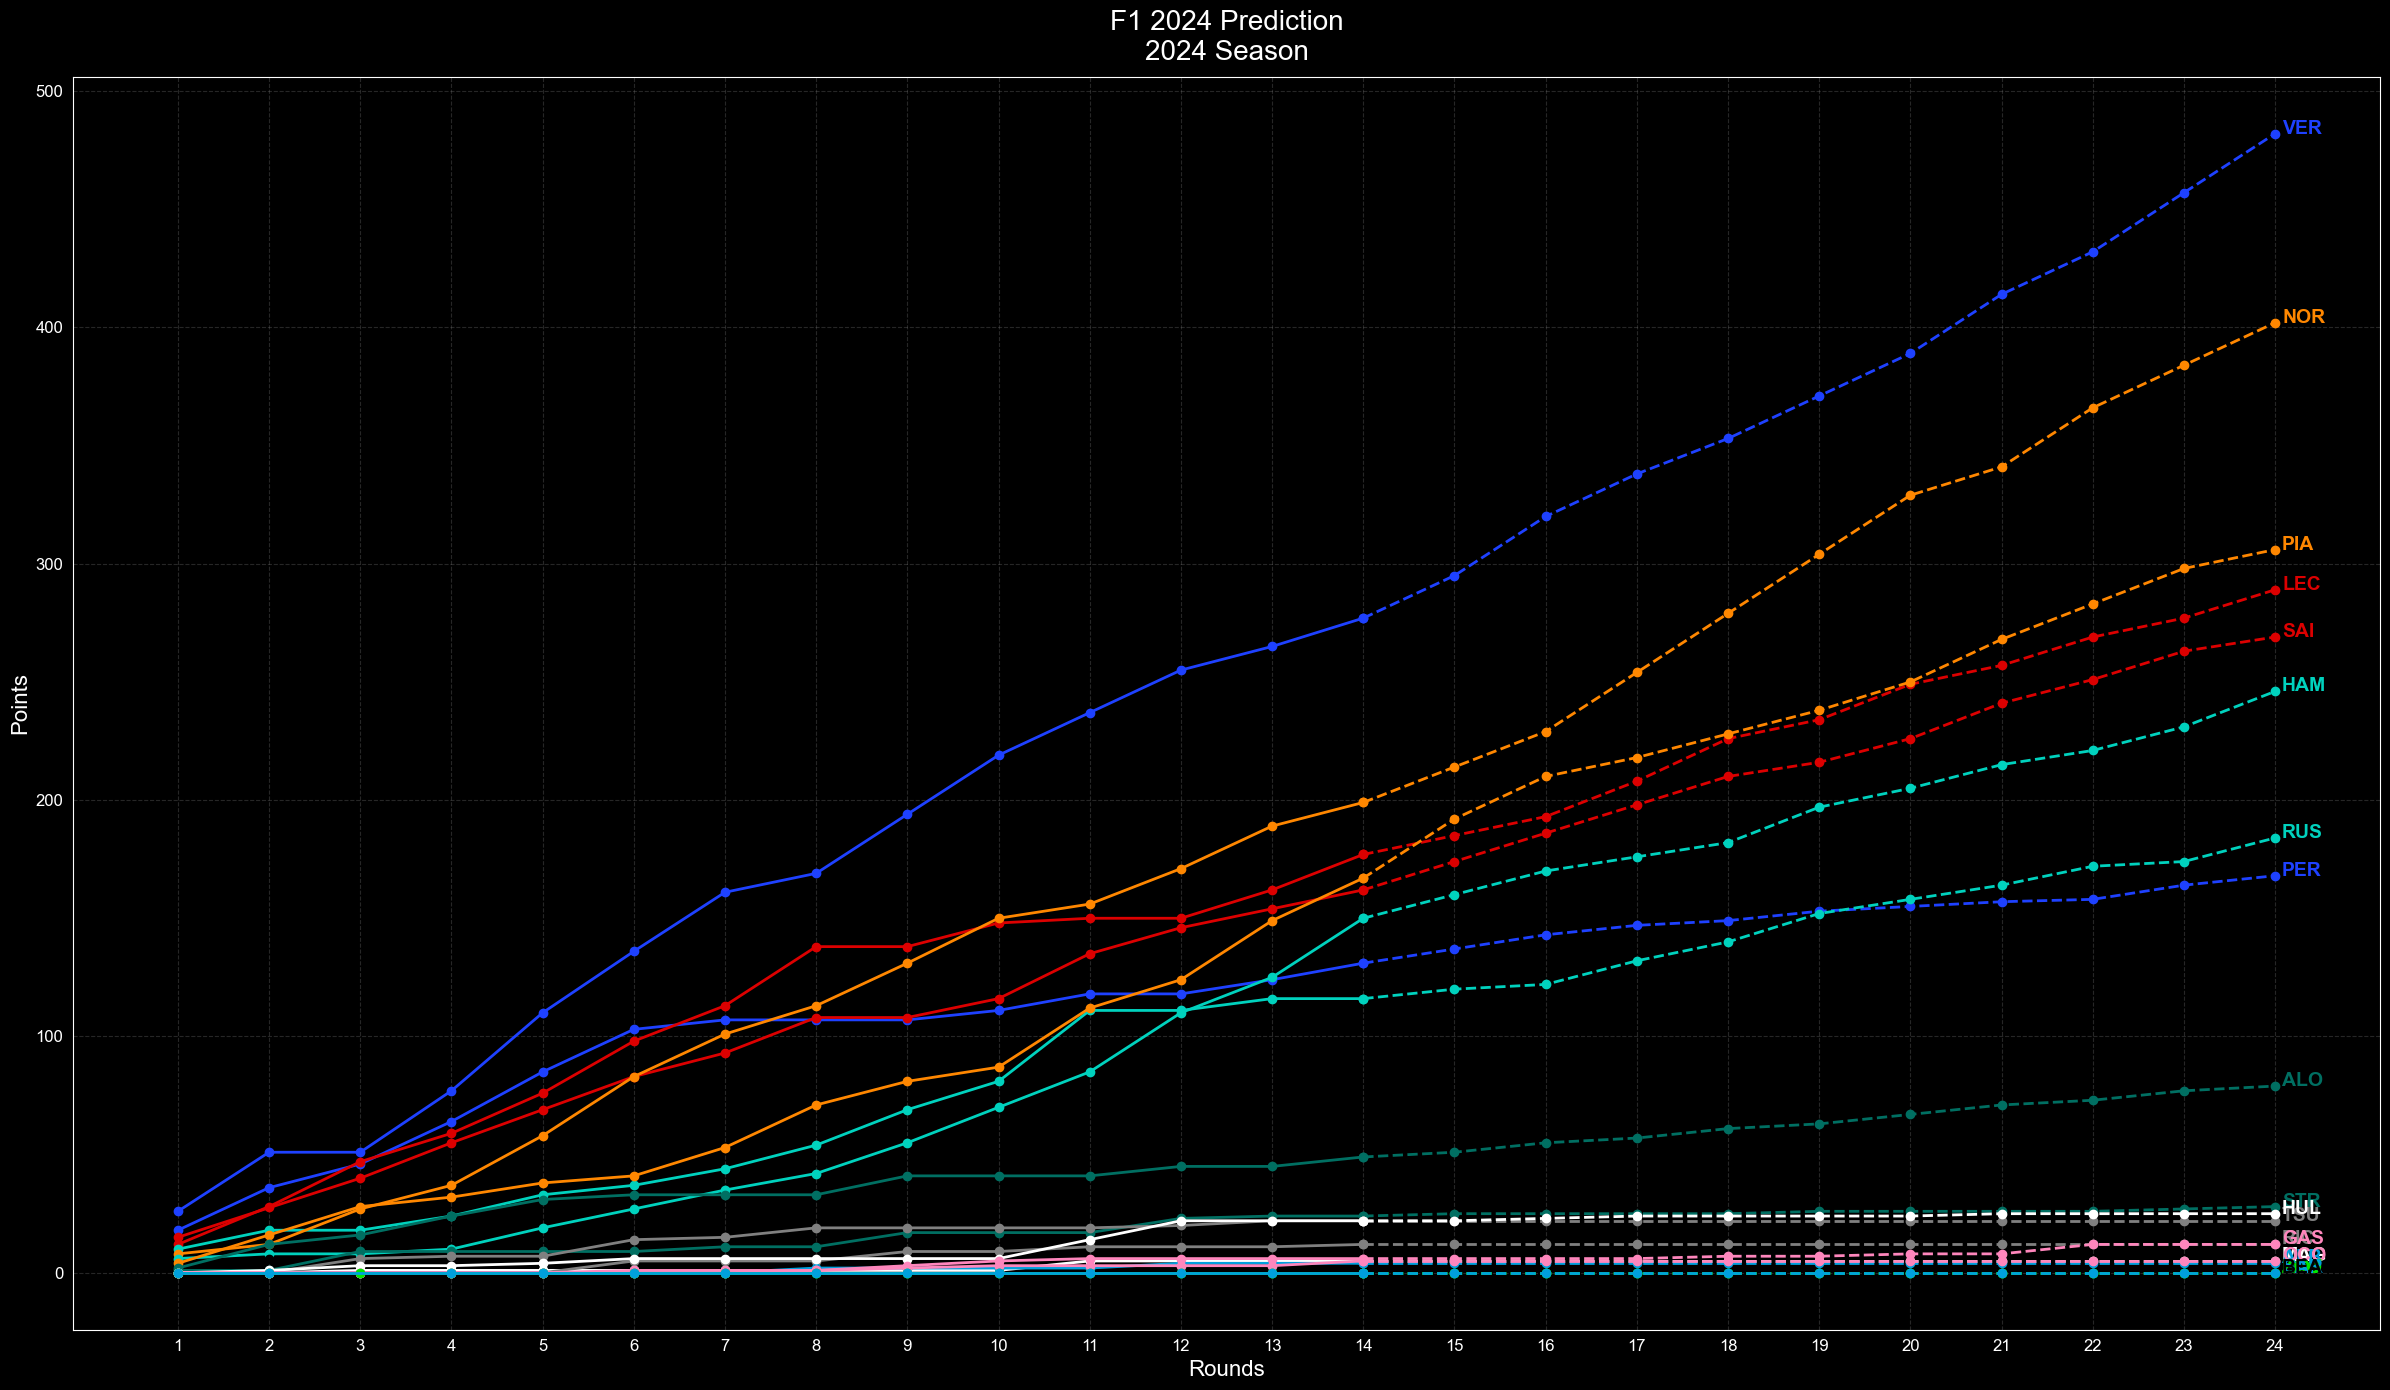

Driver Points Plot Completed.
Starting Team Points Plot...


Plotting Team Points: 100%|████████████████████| 10/10 [00:00<00:00, 151.63it/s]


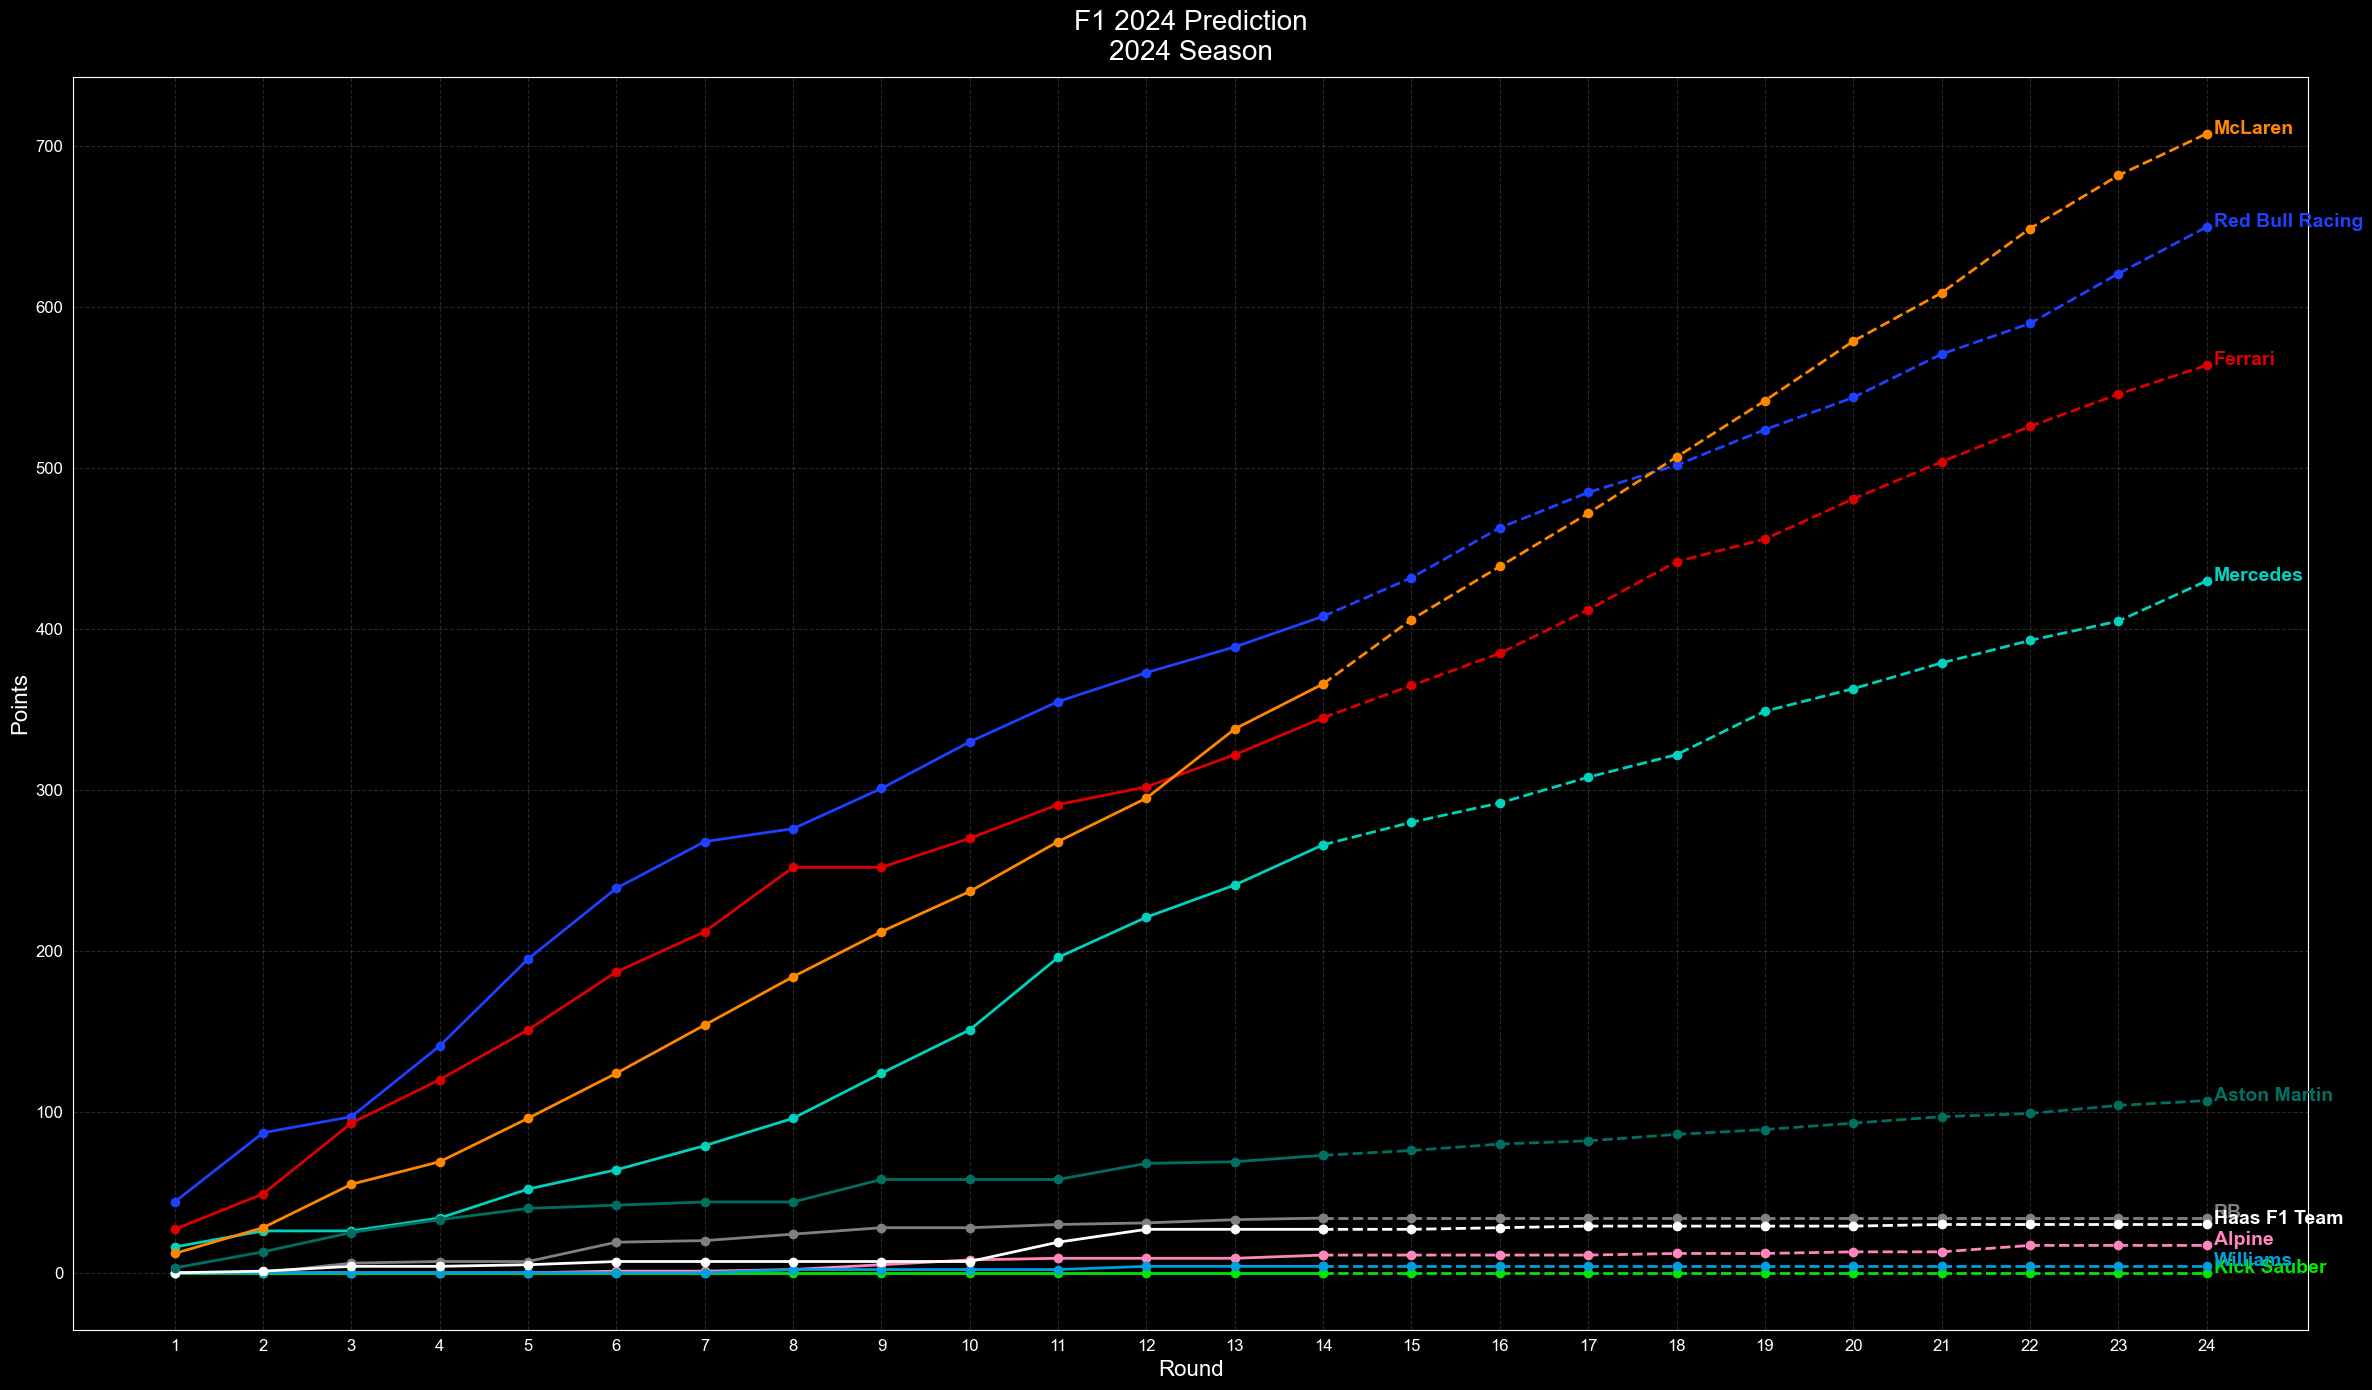

Team Points Plot Completed.


In [17]:
# Set plot style
plt.style.use('dark_background')
sns.set_style("darkgrid")

# Create a manual mapping between driver numbers and abbreviations
driver_number_to_abbreviation = {
    '1': 'VER',   # Max Verstappen
    '44': 'HAM',  # Lewis Hamilton
    '11': 'PER',  # Sergio Perez
    '16': 'LEC',  # Charles Leclerc
    '55': 'SAI',  # Carlos Sainz
    '4': 'NOR',   # Lando Norris
    '81': 'PIA',  # Oscar Piastri
    '63': 'RUS',  # George Russell
    '24': 'ZHO',  # Zhou Guanyu
    '20': 'MAG',  # Kevin Magnussen
    '3': 'RIC',   # Daniel Ricciardo
    '77': 'BOT',  # Valtteri Bottas
    '31': 'OCO',  # Esteban Ocon
    '18': 'STR',  # Lance Stroll
    '10': 'GAS',  # Pierre Gasly
    '22': 'TSU',  # Yuki Tsunoda
    '23': 'ALB',  # Alex Albon
    '2': 'SAR',   # Logan Sargeant
    '27': 'HUL',  # Nico Hulkenberg
    '14': 'ALO'   # Fernando Alonso
}

# Load 2024 season data
season = 2024
ROUND = 14  
sessions = []

for round in tqdm(range(1, ROUND + 1), desc="Loading Race Sessions"):
    try:
        race_session = fastf1.get_session(season, round, 'R')
        race_session.load()
        sessions.append(race_session)
    except Exception as e:
        print(f"Unable to load data for Round {round}: {e}")

# F1 points system
points_system = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}

# Extract required data
data = []
for index, race_session in tqdm(enumerate(sessions, start=1), total=len(sessions), desc="Processing Race Data"):
    fastest_lap_driver = race_session.laps.pick_fastest()['Driver']

    # Process race data
    for _, driver_data in race_session.results.iterrows():
        position = driver_data['Position']
        points = points_system.get(position, 0)
        fastest_lap = driver_data['Abbreviation'] == fastest_lap_driver
        if fastest_lap and position <= 10:
            points += 1

        # Get Sprint points from sprint_results_df
        sprint_points_value = sprint_results_df[(sprint_results_df['Round'] == index) & 
                                                (sprint_results_df['Driver'] == driver_data['Abbreviation'])]['SprintPoints'].sum()

        data.append({
            'Round': index,
            'Driver': driver_data['Abbreviation'],
            'Team': driver_data['TeamName'],
            'RacePosition': position,
            'RacePoints': points,
            'SprintPoints': sprint_points_value,
            'TotalPoints': points + sprint_points_value,
            'FastestLap': fastest_lap,
            'EventType': 'Race'
        })

df = pd.DataFrame(data)

# Calculate cumulative points
df['Cumulative Points'] = df.groupby('Driver')['TotalPoints'].cumsum()

# Read prediction data
predicted_points = pd.read_csv('f1_2024_predictions_trimmed.csv')

# Calculate predicted points (excluding Sprint races)
for driver in predicted_points.columns[1:]:  # Skip the 'Track' column
    predicted_points[f'{driver}_Points'] = predicted_points[driver].map(lambda x: points_system.get(x, 0))
    predicted_points[f'{driver}_Cumulative'] = predicted_points[f'{driver}_Points'].cumsum()

# Method to get team color safely
def get_team_color_safe(team_name):
    if team_name == 'Red Bull Racing':
        return '#1E41FF'  # Blue for Red Bull
    elif team_name == 'RB':
        return '#808080'  # Gray for AlphaTauri (RB)
    try:
        return fastf1.plotting.team_color(team_name)
    except KeyError:
        print(f"Warning: Color not found for team '{team_name}'. Using default color.")
        return '#000000'  # Default to black

# Get the mapping of drivers to teams
driver_team_mapping = {
    'VER': 'Red Bull Racing',
    'PER': 'Red Bull Racing',
    'HAM': 'Mercedes',
    'RUS': 'Mercedes',
    'LEC': 'Ferrari',
    'SAI': 'Ferrari',
    'NOR': 'McLaren',
    'PIA': 'McLaren',
    'ALO': 'Aston Martin',
    'STR': 'Aston Martin',
    'OCO': 'Alpine',
    'GAS': 'Alpine',
    'BOT': 'Kick Sauber',
    'ZHO': 'Kick Sauber',
    'TSU': 'RB',
    'RIC': 'RB',
    'HUL': 'Haas F1 Team',
    'MAG': 'Haas F1 Team',
    'ALB': 'Williams',
    'SAR': 'Williams'
}

# Plot driver points
def plot_driver_points():
    fig, ax = plt.subplots(figsize=(24, 14), facecolor='black')
    ax.set_facecolor('black')

    for driver in tqdm(df['Driver'].unique(), desc="Plotting Driver Points"):
        team = driver_team_mapping.get(driver, 'Unknown')
        color = get_team_color_safe(team)

        # Plot actual points (solid line with dots)
        actual_data = df[df['Driver'] == driver].groupby('Round')['Cumulative Points'].last()
        line, = ax.plot(actual_data.index, actual_data.values, 
                        color=color, linewidth=2, marker='o', markersize=6)

        # Plot predicted points (dashed line with dots)
        if driver in predicted_points.columns:
            predicted_rounds = range(ROUND, ROUND + len(predicted_points) + 1)
            last_actual_points = actual_data.iloc[-1]
            predicted_cumulative = np.concatenate(([last_actual_points], predicted_points[f'{driver}_Cumulative'] + last_actual_points))
            ax.plot(predicted_rounds, predicted_cumulative, 
                    color=color, linestyle='--', linewidth=2, marker='o', markersize=6)

        # Add larger labels at the end of the lines
        ax.annotate(driver, (predicted_rounds[-1], predicted_cumulative[-1]), 
                    xytext=(5, 0), textcoords='offset points', 
                    fontsize=14, color=color, fontweight='bold')

    ax.set_title(f'F1 2024 Prediction\n{season} Season', fontsize=20, color='white')
    ax.set_xlabel('Rounds', fontsize=16, color='white')
    ax.set_ylabel('Points', fontsize=16, color='white')
    ax.tick_params(axis='both', colors='white', labelsize=12)
    ax.set_xticks(range(1, ROUND + len(predicted_points) + 1))
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')

    plt.tight_layout()
    plt.savefig('f1_2024_driver_points_actual_and_predicted.png', dpi=300, bbox_inches='tight', facecolor='black', edgecolor='none')
    plt.show()

# Plot team points
def plot_team_points():
    team_points = df.groupby(['Round', 'Team'])['TotalPoints'].sum().unstack(fill_value=0)
    team_cumulative_points = team_points.cumsum()

    team_list = list(set(driver_team_mapping.values()))
    predicted_team_points = pd.DataFrame(0, index=predicted_points.index, columns=team_list)
    for driver, team in driver_team_mapping.items():
        if f'{driver}_Points' in predicted_points.columns:
            predicted_team_points[team] += predicted_points[f'{driver}_Points']
    predicted_team_cumulative = predicted_team_points.cumsum()

    fig, ax = plt.subplots(figsize=(24, 14), facecolor='black')
    ax.set_facecolor('black')

    for team in tqdm(team_list, desc="Plotting Team Points"):
        color = get_team_color_safe(team)

        if team in team_cumulative_points.columns:
            line, = ax.plot(team_cumulative_points.index, team_cumulative_points[team], 
                            color=color, linewidth=2, marker='o', markersize=6)

        if team in predicted_team_cumulative.columns:
            predicted_rounds = range(ROUND, ROUND + len(predicted_points) + 1)
            last_actual_points = team_cumulative_points[team].iloc[-1] if team in team_cumulative_points.columns else 0
            predicted_cumulative = np.concatenate(([last_actual_points], predicted_team_cumulative[team] + last_actual_points))
            ax.plot(predicted_rounds, predicted_cumulative, 
                    color=color, linestyle='--', linewidth=2, marker='o', markersize=6)

        # Add larger labels at the end of the lines
        ax.annotate(team, (predicted_rounds[-1], predicted_cumulative[-1]), 
                    xytext=(5, 0), textcoords='offset points', 
                    fontsize=14, color=color, fontweight='bold')

    ax.set_title(f'F1 2024 Prediction\n{season} Season', fontsize=20, color='white')
    ax.set_xlabel('Round', fontsize=16, color='white')
    ax.set_ylabel('Points', fontsize=16, color='white')
    ax.tick_params(axis='both', colors='white', labelsize=12)
    ax.set_xticks(range(1, ROUND + len(predicted_points) + 1))
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')

    plt.tight_layout()
    plt.savefig('f1_2024_team_points_actual_and_predicted.png', dpi=300, bbox_inches='tight', facecolor='black', edgecolor='none')
    plt.show()

print("Starting Driver Points Plot...")
plot_driver_points()
print("Driver Points Plot Completed.")

print("Starting Team Points Plot...")
plot_team_points()
print("Team Points Plot Completed.")

# Conclusion

**Teams:** McLaren's strong momentum is expected to surpass Red Bull in total points by the 18th round in Singapore, and they are likely to maintain this lead to become the 2024 Constructors' Champion. Red Bull may continue to be held back by Perez's inconsistent performance. Ferrari and Mercedes will remain competitive for third place, mainly due to the continued consistency of the two Ferrari drivers. Despite Ferrari's downward momentum and Mercedes' upward momentum, the model predicts that Ferrari will consistently secure third place, with both teams unable to challenge Red Bull and McLaren's positions. Aston Martin is expected to remain in a solid but isolated fifth place. The bottom five teams are very close in performance, but because their chances of scoring points are so low, it is difficult to predict any changes in rankings.

**Drivers:** The gap between Norris and Verstappen is expected to narrow further, but given Verstappen's exceptional skill, consistency, and the points advantage he accumulated in the first 14 rounds, he is still predicted to win the Drivers' Championship. Among the title contenders, Piastri's performance is predicted to be very close to that of Leclerc and Sainz, with the model showing that the McLaren driver is likely to overtake Leclerc soon and eventually secure third place in the Drivers' Championship. Leclerc and Sainz are expected to maintain stable performances and finish fourth and fifth. Interestingly, Hamilton is predicted to rapidly close the gap and join the fight in the second half of the season, while Russell is expected to overtake Perez in the 20th round in Mexico, Perez's home race. 

It should be noted that this prediction does not include points from the three upcoming Sprint races. If Sprint race results are included, the competition among the title contenders could become even more intense. 

Let's look forward to the final 10 F1 races of 2024!

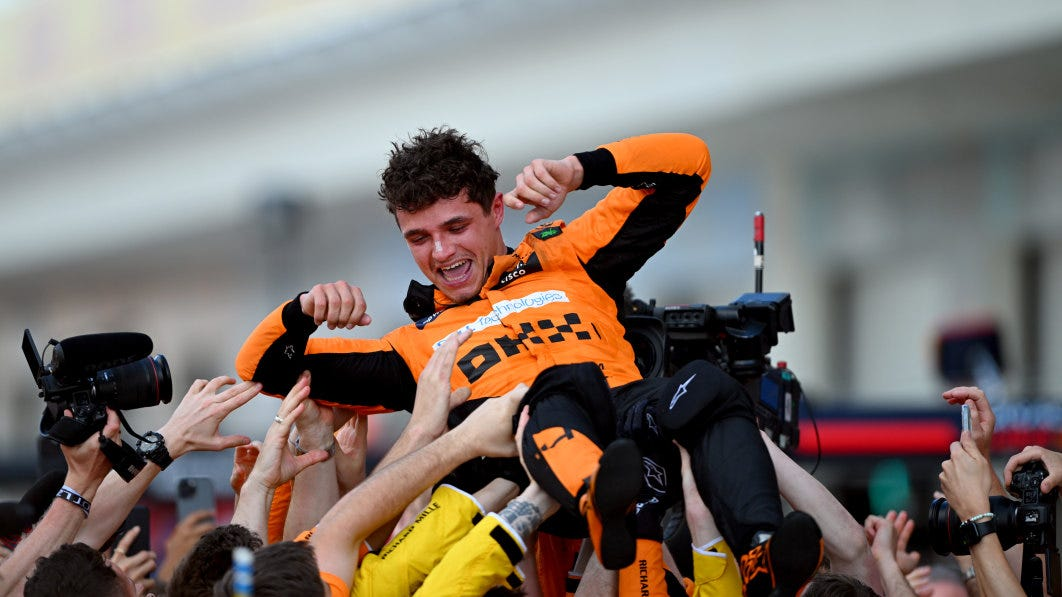

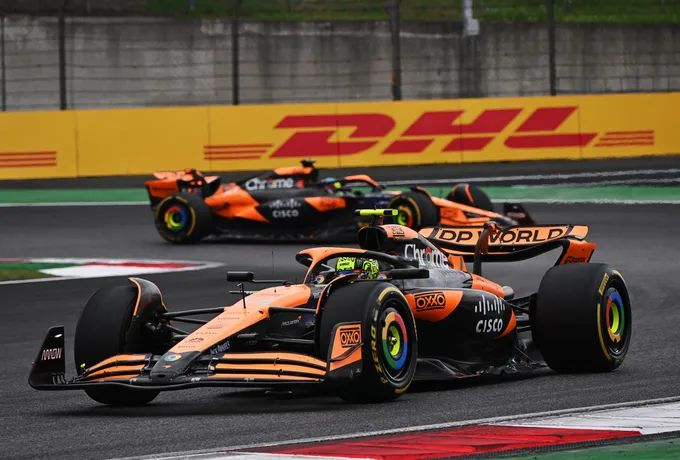